# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

import torch

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

sns.set(style="whitegrid")
# sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

from vol_predict.backtest.benchmark_backtester import BenchmarkBacktester
from vol_predict.models.baselines.benchmarks import Naive, EWMA, ARIMAX, GARCH

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
full_data = (
    (
        pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
        .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
        .sort("datetime")
    )
    .select(["datetime", "vol"])
    .to_pandas()
    .set_index("datetime")
)

In [4]:
NUM_LAGS = 1

for i in range(1, NUM_LAGS + 1):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log vol
full_data["log_vol"] = np.log(full_data["vol"])

for i in range(1, NUM_LAGS + 1):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)

# drop NaN values
full_data = full_data.dropna()

In [5]:
LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")
init_training_vola = full_data.loc[:LAST_TRAINING_DATE].dropna()

# additionally split the init_training_vola into train and validation sets
validation_ts = datetime.strptime("2018-06-25 00:00:00", "%Y-%m-%d %H:%M:%S")
mini_training_set = init_training_vola.loc[: validation_ts - pd.Timedelta(hours=1), :]
validation_set = init_training_vola.loc[validation_ts:, :]

Text(0.5, 0, 'Date')

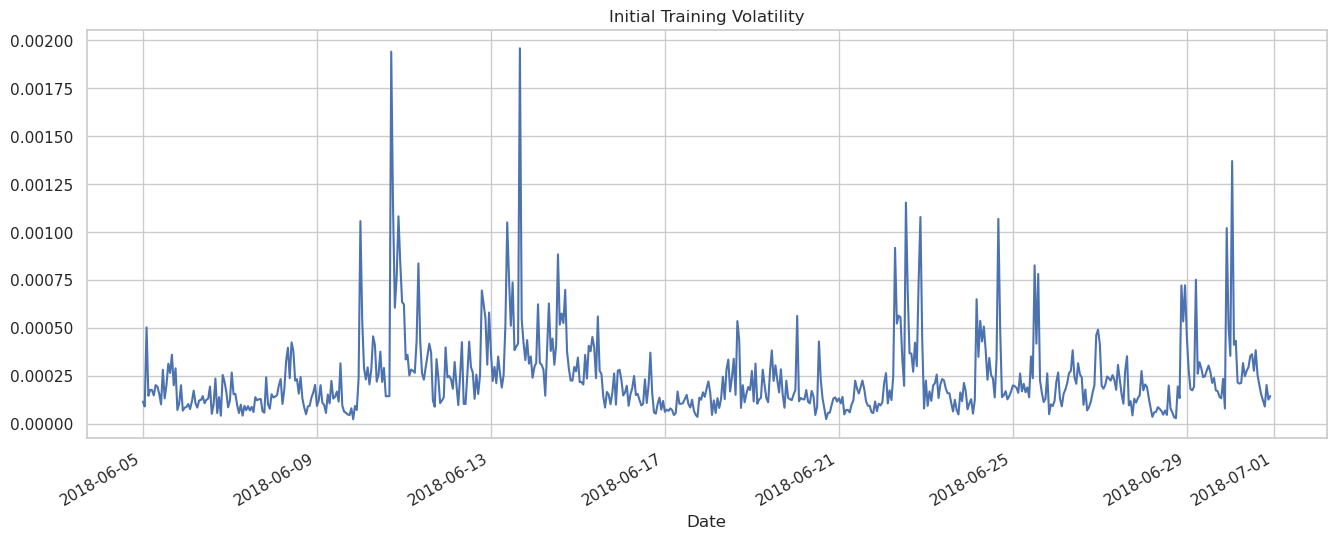

In [6]:
init_training_vola.loc[:, "vol"].plot()
plt.title("Initial Training Volatility")
plt.xlabel("Date")

Text(0.5, 0, 'Date')

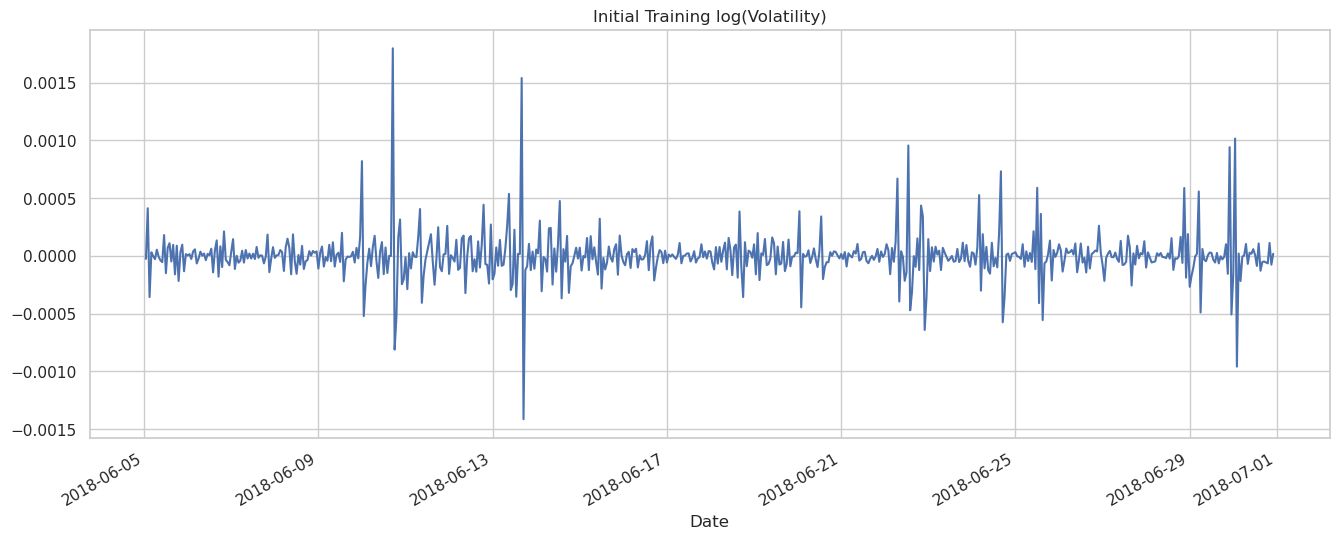

In [7]:
diff(init_training_vola.vol).plot()
plt.title("Initial Training log(Volatility)")
plt.xlabel("Date")

Text(0.5, 1.0, 'Initial Training Volatility')

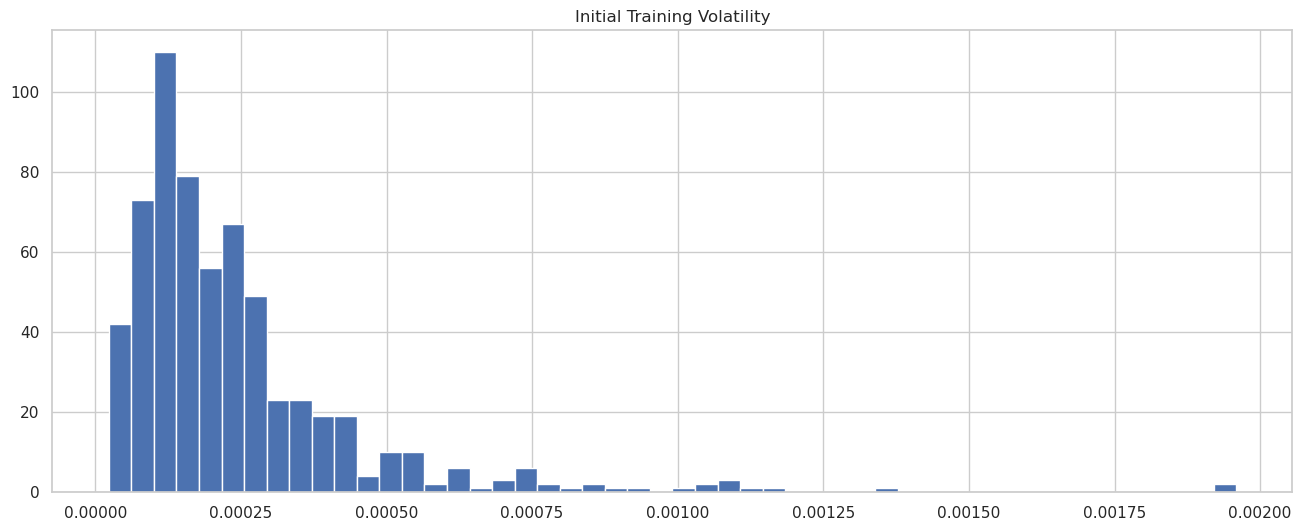

In [8]:
plt.hist(init_training_vola.vol, bins=50)
plt.title("Initial Training Volatility")

Text(0.5, 1.0, 'Initial Training log(Volatility)')

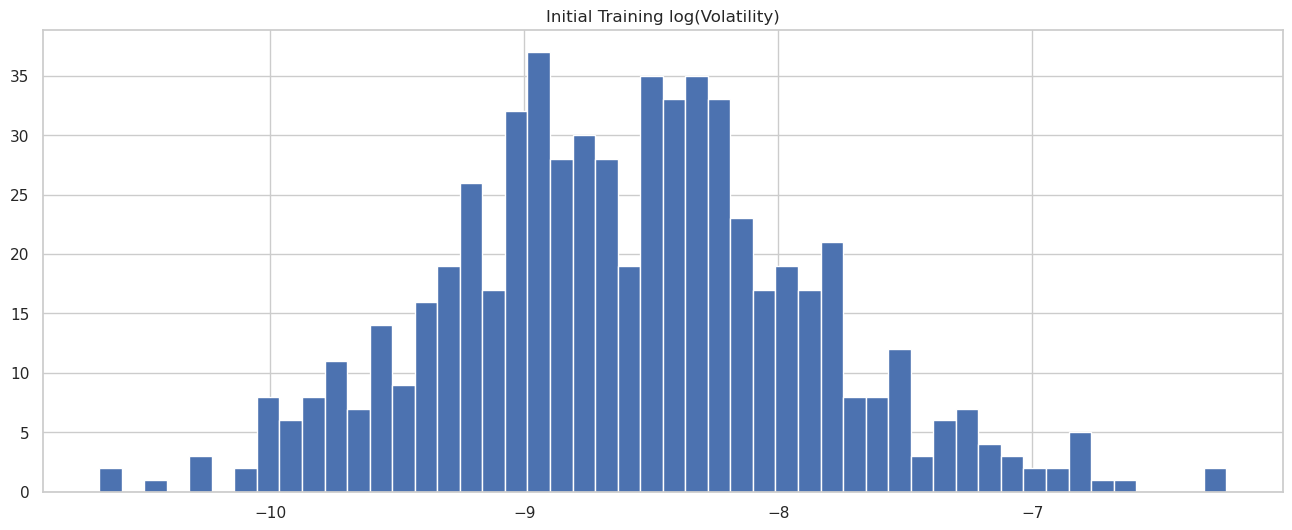

In [9]:
plt.hist(np.log(init_training_vola.vol), bins=50)
plt.title("Initial Training log(Volatility)")

Test normality of log-volatility


In [10]:
jarque_bera(np.log(init_training_vola.vol))

# RETURNS
#     The Jarque-Bera test statistic.
#     The pvalue of the test statistic.
#     Estimated skewness of the data.
#     Estimated kurtosis of the data.

(3.138552497536423,
 0.2081958098158484,
 0.15537921120790968,
 3.1578656316016143)

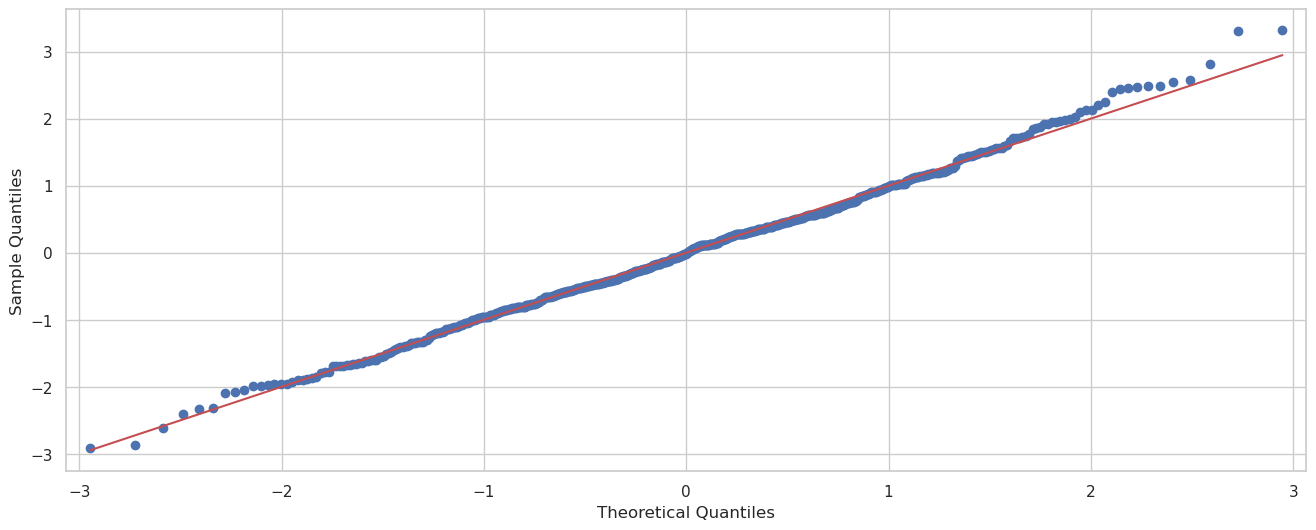

In [11]:
# qq plot of residuals
sm.qqplot(
    np.log(init_training_vola.vol),
    line="s",
    fit=True,
);

Seems like the log-volatility is very close to normal.

## Stationarity tests

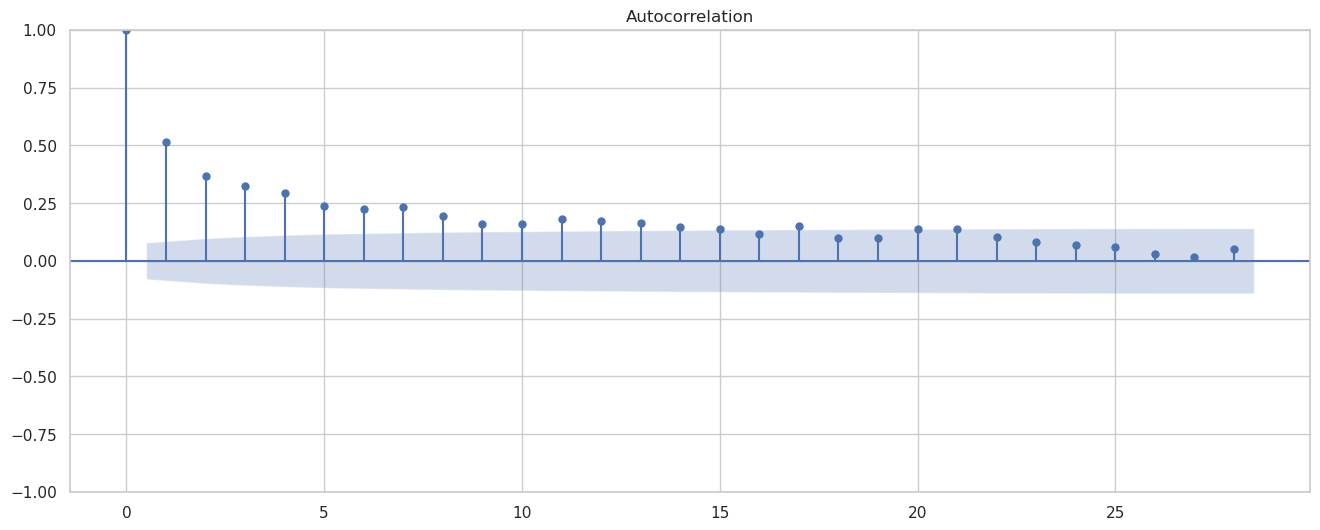

In [12]:
# acf and pcf plots
plot_acf(init_training_vola.vol, ax=None);

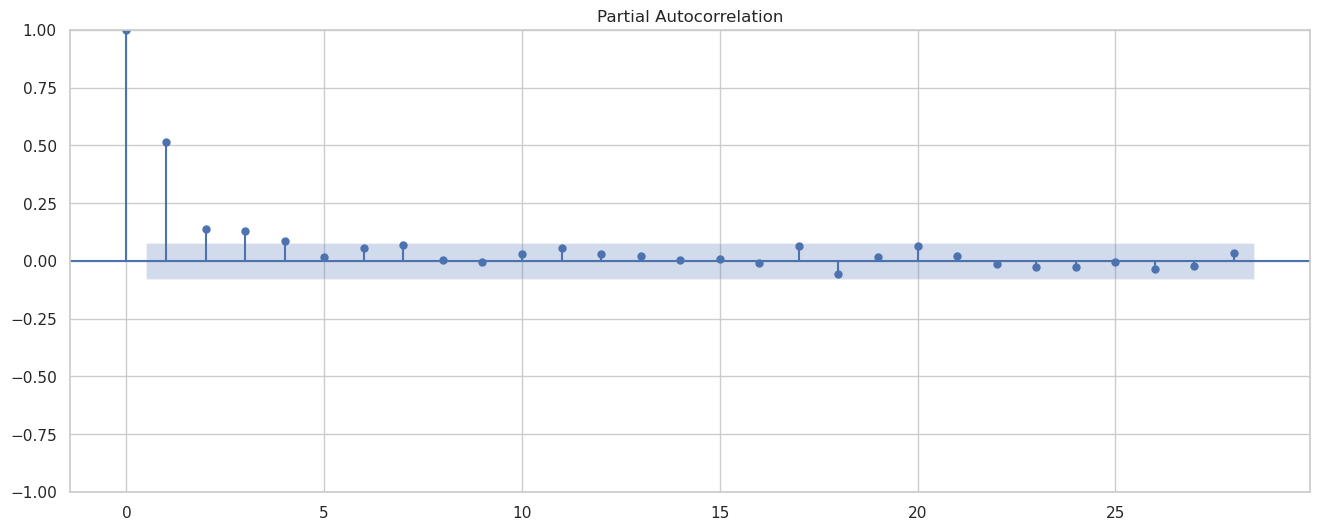

In [13]:
plot_pacf(init_training_vola.vol);

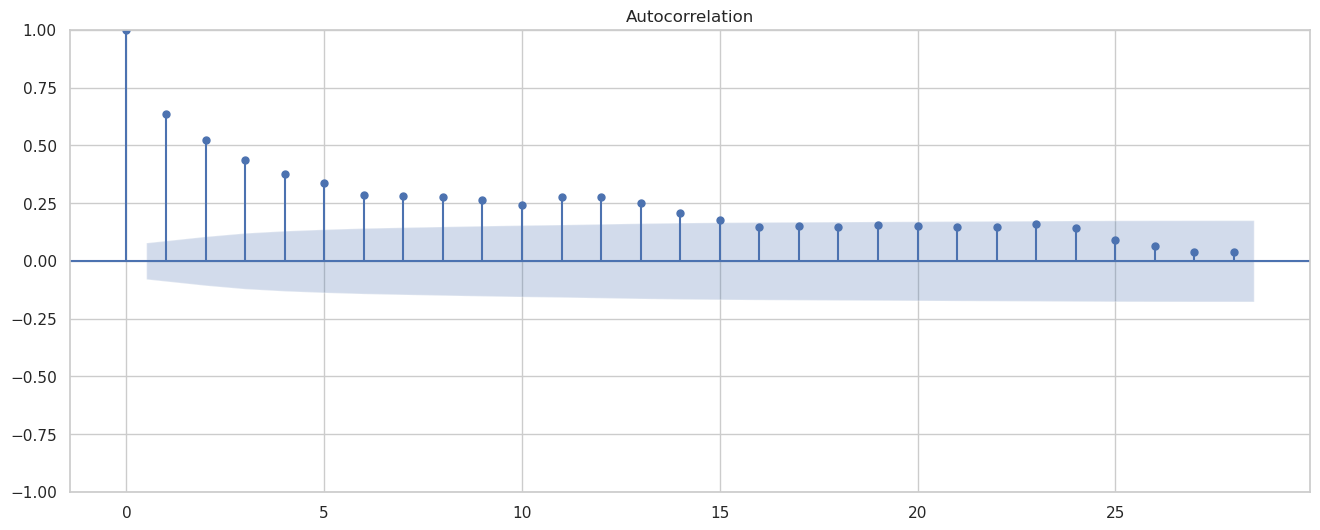

In [14]:
plot_acf(np.log(init_training_vola.vol));

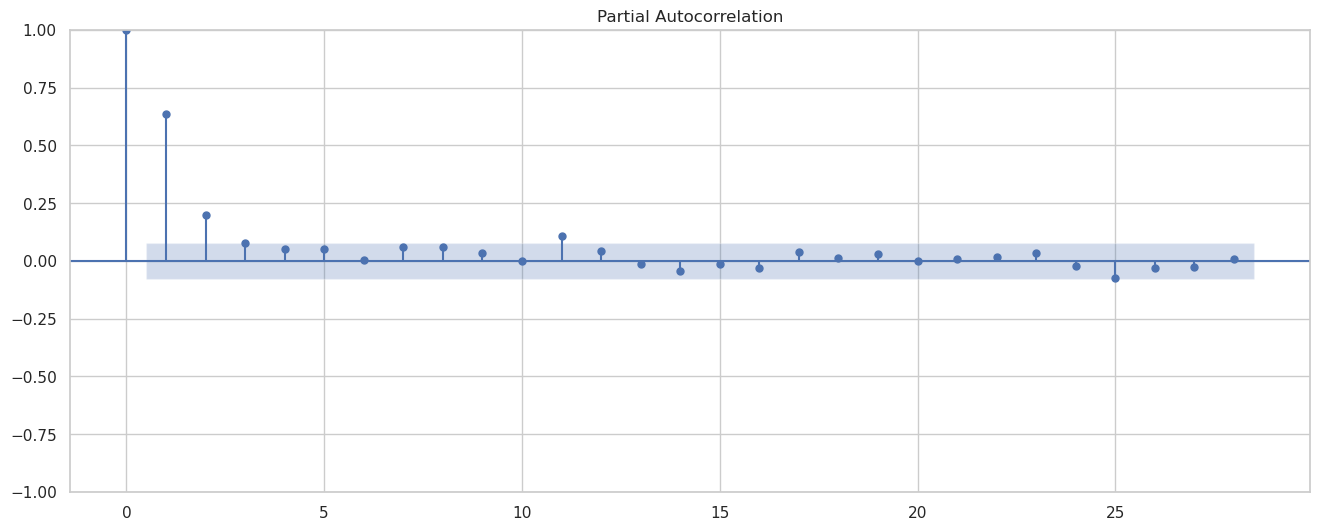

In [15]:
plot_pacf(np.log(init_training_vola.vol));

ACF is expected to have a slow decay and all positive autocorrelation coefficients.
PACF sharply goes to zero, a few positive significant lags and no seasonal spikes are present. 
Both results are due to "volatility clustering", but no long-term dependencies are present. 

### ADF

For maximal number of lags we use the default value (very large, orders of 100). For each number of lags, and each `regression` parameter in `c`, `ct`, `n` we compare AIC and BIC. 
`regression=c` minimizes both AIC and BIC, followed by `ct`. So we will test the null hypothesis of unit root with alternative of stationarity with a drift (constant) without the trend (which is obvious from the plot of differenced series of volatility). 


For AIC, the optimal number of lags is 3 whereas for BIC is 2. So we will choose 3 as the number of lags as PACF shows a bit longer memory then just 2 lags (it indicates 3 or maybe 4 lags).

In [16]:
adfuller(
    init_training_vola.vol, regression="c", autolag="AIC"
)  # tweak the two parameters to get results stated above

(-7.404567388216078,
 7.4028332649633e-11,
 3,
 616,
 {'1%': -3.4410103235939746,
  '5%': -2.866243374831338,
  '10%': -2.5692748053002195},
 -8642.21908868115)

We can reject the null hypothesis of unit root with alternative of stationarity with a drift (constant).

### KPSS test

ADF is some weak of a test, so let's test the stationarity with KPSS test. The null hypothesis is a stationary process

In [17]:
def kpss_test(timeseries, regression):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [18]:
kpss_test(init_training_vola.vol.values, regression="c")

Results of KPSS Test:
Test Statistic            0.15874
p-value                   0.10000
Lags Used                13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/tmp/ipykernel_364343/2930837317.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags="auto")


We can not reject the null hypothesis of stationarity with a drift (constant). 

The KPSS with the alternative of stationarity with a trend (`regression='ct'`) has a significant p-value, but that is not relevant since we are confident there is not trend in volatility.

# Naive prediction

Naive prediction is the last observation of volatility.

In [19]:
mse(
    init_training_vola.loc[:, "vol"].values,
    init_training_vola.loc[:, "vol_lag1"].values,
) ** 0.5

0.0002081006908249498

In [20]:
mae(
    init_training_vola.loc[:, "vol"].values,
    init_training_vola.loc[:, "vol_lag1"].values,
)

0.00011488744937734579

# Exponentially Weighted Moving Average (EWMA)

$$
\hat{y}_t = \alpha \sum_{i=1}^T \beta^{t-i} y_{t-i}
$$

where:
- $\hat{y}_t$ is the forecast for time $t$
- $y_{t}$ is the observed value at time $t$ 
- $\alpha$ is the normalization factor,  `normlaization_factor` in code
- $\beta$ is the forgetting factor (0 < $\beta$ < 1), `forgetting_factor`
- $T$ is the number of observations, `ewma_look_back_win` 

Optimization should done on a `raw_forgetting_factor` which is on $\mathbb{R}$, mapping is done as
`forgetting_factor = torch.sigmoid(raw_forgetting_factor)`. The interpretable value of the forgetting factor is the half-life, and the method `EWMAPredictor.get_half_life()`  returns the half-life.

We will determine the forgetting factor via a grid search.

In [21]:
class EWMAPredictor:
    """
    Exponentially Weighted Moving Average (EWMA) volatility predictor. Given the past volatility,
    average them by weighting the most recent ones more heavily. The forgetting factor and half-life
    are related as follows:

    forgetting_factor = 0.5 ** (1 / half_life)

    """

    def __init__(
        self,
        ewma_look_back_win: int,
        ewma_half_life: float,
        *args,
        **kwargs,
    ):
        # super().__init__()

        assert ewma_look_back_win > 0.0, "ewma_look_back_win must be greater than 0"
        assert ewma_half_life > 0.0, "ewma_half_life must be greater than 0"
        self.look_back = ewma_look_back_win
        self.half_life = ewma_half_life
        self.forgetting_factor = self._hl_to_ff(torch.Tensor([self.half_life]))

        self.exp_weights = torch.zeros((self.look_back))
        for i in range(self.look_back):
            self.exp_weights[i] = self.forgetting_factor ** (i)

        self.normalization_const = (1 - self.forgetting_factor) / (
            1 - self.forgetting_factor**self.look_back
        )

        # # forgetting_factor is bounded between 0 and 1
        # # if needed, raw_forgetting_factor is an unbounded version of forgetting_factor
        # # sigmoid_inverse(3.4) = 0.9677, which is a forgetting_factor equivalent to half-life of 21
        # self.raw_forgetting_factor = Parameter(torch.Tensor([3.4]), requires_grad=True)
        # self.forgetting_factor = torch.sigmoid(self.raw_forgetting_factor)

    def _hl_to_ff(self, half_life: torch.Tensor) -> torch.Tensor:
        """
        Convert half-life to forgetting factor.
        """
        assert half_life.item() > 0.0, "half_life must be greater than 0"
        return torch.Tensor(0.5 ** (1 / half_life))

    def _ff_to_hl(self, forgetting_factor: torch.Tensor) -> torch.Tensor:
        """
        Convert forgetting factor to half-life.
        """
        assert forgetting_factor.item() > 0.0, (
            "forgetting_factor must be greater than 0"
        )
        assert forgetting_factor.item() < 1.0, "forgetting_factor must be less than 1"
        return -torch.log(torch.tensor(2.0)) / torch.log(
            torch.tensor(forgetting_factor)
        )

    def _forward(
        self,
        past_returns: torch.Tensor,
        past_vols: torch.Tensor,
        features: torch.Tensor,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        calculation_win = min(self.look_back, past_vols.shape[0])
        if calculation_win == 0:
            return None
        elif calculation_win == self.look_back:
            return self.normalization_const * torch.sum(
                self.exp_weights * past_vols[-calculation_win:]
            )
        else:
            # if we don't have enough data, we need to normalize the weights
            normalization_const = (1 - self.forgetting_factor) / (
                1 - self.forgetting_factor**calculation_win
            )
            return normalization_const * torch.sum(
                self.exp_weights[:calculation_win] * past_vols[-calculation_win:]
            )

### Tune `look_back` and `half_life` parameters

In [22]:
# make a grid of look_back and half_life, and test the model
def test_ewma_predictor(
    ewma_look_back_win: int,
    ewma_half_life: float,
    volatility: torch.Tensor,
):
    """
    volatility: tensor of shape (n, 2), where n is the number of samples
    and the first column is the original volatility and the second column is the lagged volatility
    """
    ewma_predictor = EWMAPredictor(
        ewma_look_back_win=ewma_look_back_win, ewma_half_life=ewma_half_life
    )

    predicted_vola = torch.zeros(volatility.shape[0])

    for i in range(ewma_look_back_win, len(predicted_vola)):
        predicted_vola[i] = ewma_predictor._forward(
            past_returns=None,
            past_vols=volatility[i - ewma_look_back_win : i, 1],  # lagged vola column
            features=None,
        )

    rmse_ewma = (
        mse(
            predicted_vola[ewma_look_back_win:],
            volatility[ewma_look_back_win:, 0],
        )
        ** 0.5
    )
    mae_ewma = mae(
        predicted_vola[ewma_look_back_win:],
        volatility[ewma_look_back_win:, 0],
    )

    l2_disp = (
        (
            (predicted_vola[ewma_look_back_win:] - volatility[ewma_look_back_win:, 0])
            ** 2
        )
        .std()
        .sqrt()
        .item()
    )
    l1_disp = (
        (predicted_vola[ewma_look_back_win:] - volatility[ewma_look_back_win:, 0])
        .std()
        .item()
    )

    return rmse_ewma, mae_ewma, l2_disp, l1_disp

In [23]:
init_training_vola.shape

(620, 4)

In [24]:
test_ewma_predictor(
    ewma_look_back_win=24,
    ewma_half_life=21,
    volatility=torch.tensor(init_training_vola.values),
)

(0.00021066792838729827,
 0.00013076106464554788,
 0.00042987075447090367,
 0.00021083351289346246)

In [25]:
look_back_grid = [1, 3, 6, 12, 24, 48]
half_life_grid = [1, 3, 6, 12, 24, 48]
results = []
for look_back in look_back_grid:
    for half_life in half_life_grid:
        rmse_ewma, mae_ewma, l2_disp, l1_disp = test_ewma_predictor(
            ewma_look_back_win=look_back,
            ewma_half_life=half_life,
            volatility=torch.tensor(init_training_vola.values),
        )
        results.append(
            {
                "look_back": look_back,
                "half_life": half_life,
                "rmse": rmse_ewma,
                "mae": mae_ewma,
                "l2_disp": l2_disp,
                "l1_disp": l1_disp,
            }
        )
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["rmse", "mae"], ascending=[True, True])
results_df

,look_back,half_life,rmse,mae,l2_disp,l1_disp
23,12,48,0.000204,0.000126,0.000416,0.000204
17,6,48,0.000204,0.000126,0.000407,0.000204
16,6,24,0.000205,0.000126,0.000407,0.000205
22,12,24,0.000205,0.000126,0.000416,0.000205
15,6,12,0.000205,0.000127,0.000407,0.000205
21,12,12,0.000207,0.000128,0.000417,0.000207
14,6,6,0.000207,0.000128,0.000406,0.000207
29,24,48,0.000208,0.000129,0.000427,0.000209
11,3,48,0.000210,0.000123,0.000424,0.000210
10,3,24,0.000210,0.000123,0.000423,0.000210


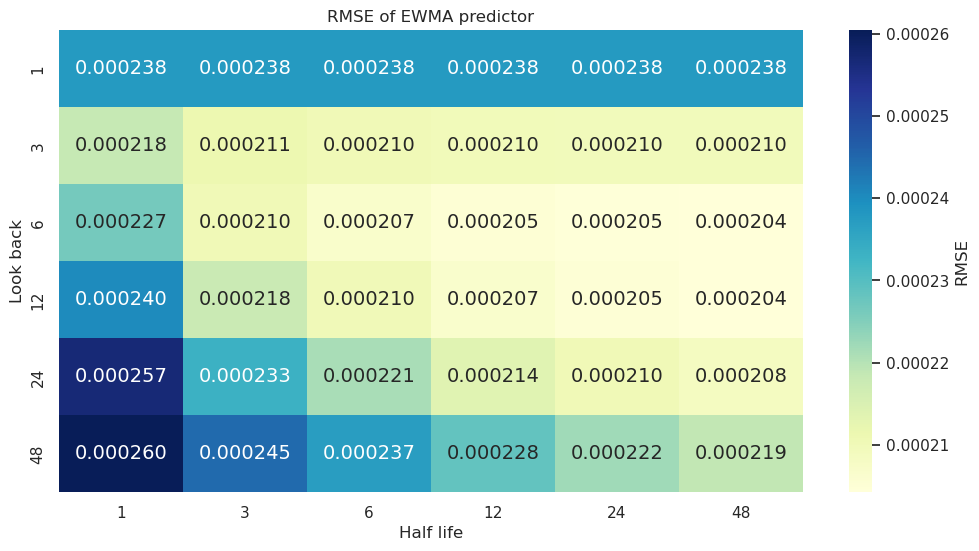

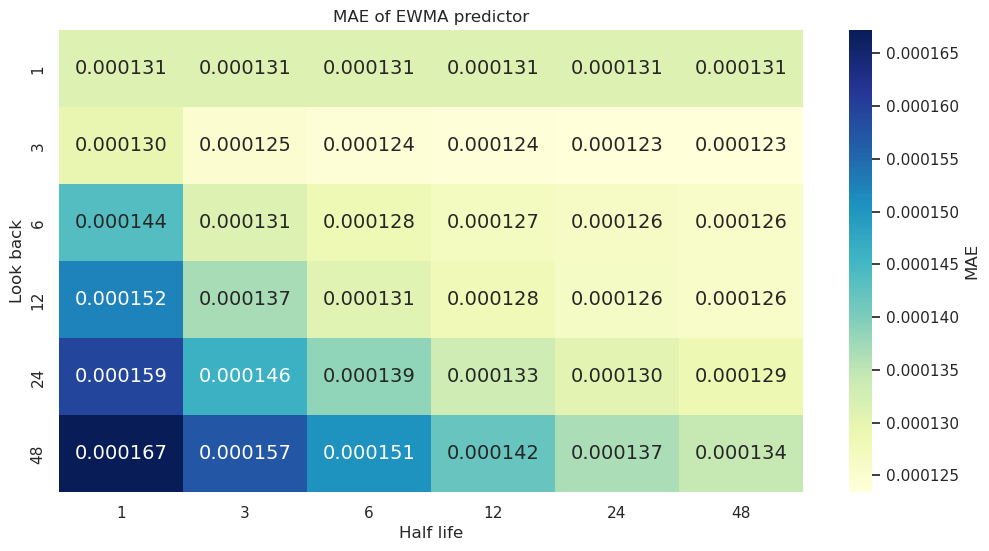

In [26]:
# plot heatmap of rmse and mae
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="rmse",
    ),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    cbar_kws={"label": "RMSE"},
)
plt.title("RMSE of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="mae",
    ),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    cbar_kws={"label": "MAE"},
)
plt.title("MAE of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()

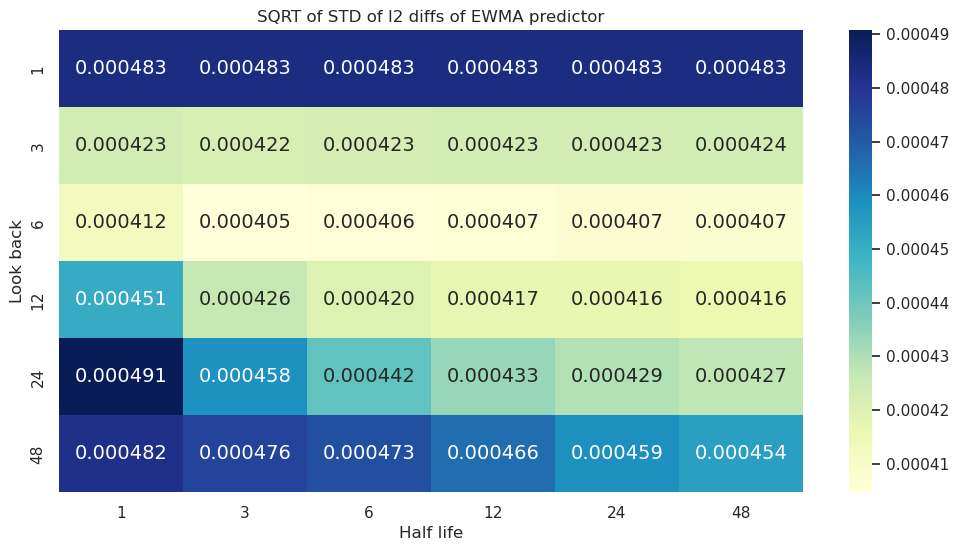

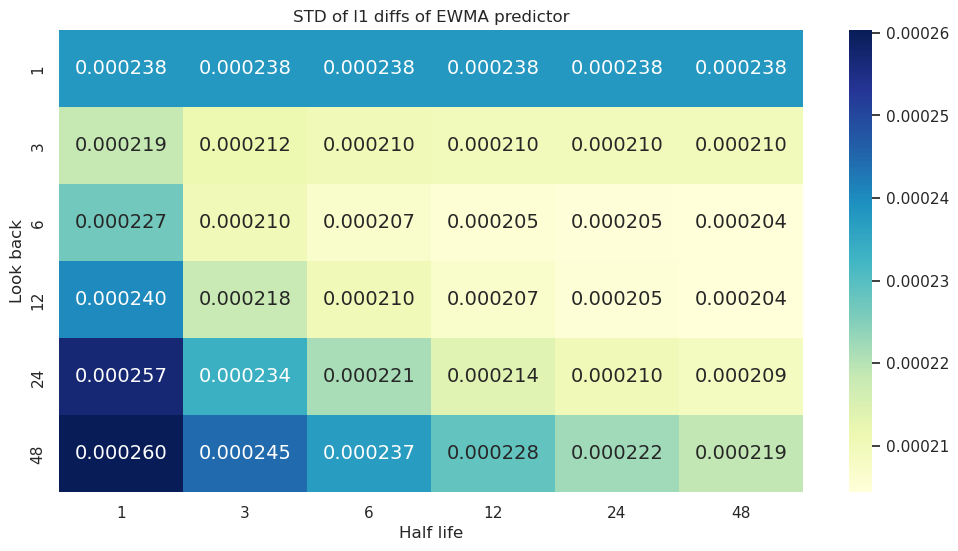

In [27]:
# plot heatmap of l1 and l2 residuals dispersion
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="l2_disp",
    ),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    # cbar_kws={"label": "RMSE STD"},
)
plt.title("SQRT of STD of l2 diffs of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()
plt.figure(figsize=(12, 6))
sns.heatmap(
    results_df.pivot(
        index="look_back",
        columns="half_life",
        values="l1_disp",
    ),
    annot=True,
    fmt=".6f",
    cmap="YlGnBu",
    # cbar_kws={"label": "MAE STD"},
)
plt.title("STD of l1 diffs of EWMA predictor")
plt.xlabel("Half life")
plt.ylabel("Look back")
plt.show()

We will pick the parameters such that both RMSE and MAE are near the optimal values obtained in the previous test.

Increasing half-life increases the performance in both metrics, but the difference is negligible after 12 or 24 days.

For RMSE the optimal look-back window is 6, with 3 and 12 following closely. 
For MAE the optimal look-back window is 3, and 6 having following results.

**We will chose 6 days for look-back window and 12 for the half-life**. We could have used 24 for the half-life, but it would put almost equal weights, making EWMA similar to a simple moving average.

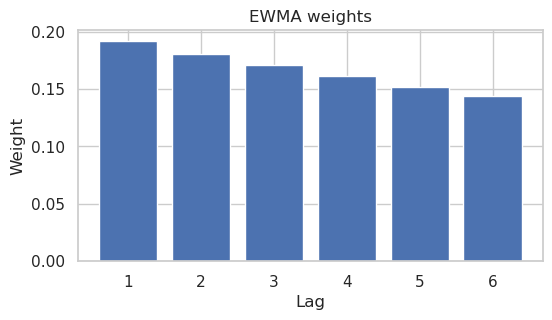

In [28]:
# plot histogram of weights
ewma_predictor = EWMAPredictor(ewma_look_back_win=6, ewma_half_life=12)

plt.figure(figsize=(6, 3))
plt.bar(
    range(1, ewma_predictor.look_back + 1),
    ewma_predictor.exp_weights.detach().numpy()
    * ewma_predictor.normalization_const.detach().numpy(),
)
plt.title("EWMA weights")
plt.xlabel("Lag")
plt.ylabel("Weight")
plt.show()

In [29]:
LOOK_BACK_WIN = 6
HALF_LIFE = 12
ewma_predictor = EWMAPredictor(
    ewma_look_back_win=LOOK_BACK_WIN,
    ewma_half_life=HALF_LIFE,
)

In [30]:
test_ewma_predictor(
    ewma_look_back_win=6,
    ewma_half_life=12,
    volatility=torch.tensor(init_training_vola.values),
)
# rmse_ewma, mae_ewma, l2_disp, l1_disp

(0.00020526903232207698,
 0.0001268413131624884,
 0.0004065953086440846,
 0.00020543602988858082)

# ARIMA

## Tuning parameters (p,q) in an In-sample analysis

In [31]:
from statsmodels.tsa.arima.model import ARIMA

In [32]:
# Determines the p and q that minimizes the AIC
def find_p_q(ts, max_p, max_q, criteria="aic"):
    p_q_table = pd.DataFrame(index=range(max_p + 1), columns=range(max_q + 1))
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            model = ARIMA(ts, order=(p, 0, q))
            fit = model.fit(method_kwargs={"maxiter": 1000})
            if criteria == "aic":
                p_q_table.loc[p, q] = fit.aic
            elif criteria == "bic":
                p_q_table.loc[p, q] = fit.bic
    return p_q_table


# Plots the residuals including their density
def plot_residuals(model):
    resids = model.resid[1:]
    fig, ax = plt.subplots(1, 2)
    resids.plot(title="Residuals", ax=ax[0])
    resids.plot(title="Density", kind="kde", ax=ax[1])
    plt.show()

**Important:** optimization routine does not converge on raw volatility. This is not surprising given the distribution of raw volatility is far from Normal. We will use log volatility.

In [33]:
p_max = 5
q_max = 5
aic_p_q = find_p_q(
    init_training_vola.log_vol.values, max_p=p_max, max_q=q_max, criteria="aic"
)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Text(0.5, 54.249999999999986, 'q')

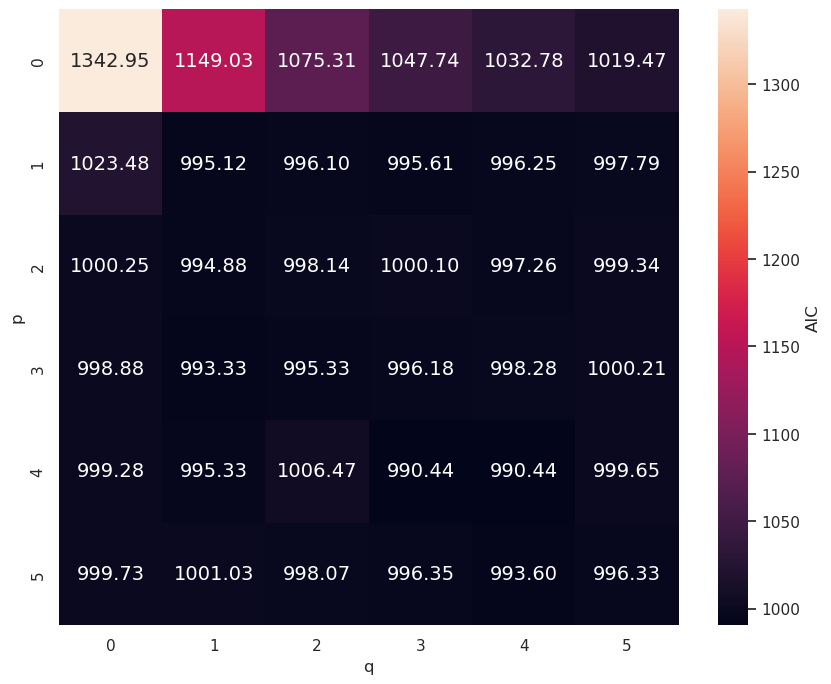

In [34]:
# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    aic_p_q.astype(float),
    annot=True,
    fmt=".2f",
    # cmap="YlGnBu",
    cbar_kws={"label": "AIC"},
)
plt.ylabel("p")
plt.xlabel("q")

In [35]:
# find the best p, q
best_p, best_q = np.unravel_index(np.argmin(aic_p_q.values), aic_p_q.shape)
print(f"Best p: {best_p}, Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

Best p: 4, Best q: 3
Best AIC: 990.4362860967625


Since ARIMA(4,0,3) and ARIMA(4,0,4) have similar AIC, we will use ARIMA(4,0,3) as it has lower BIC, and adding new term makes a few coefficients insignificant.

In [36]:
arima = ARIMA(
    endog=init_training_vola.log_vol.values,
    order=(4, 0, 3),
)
arima_results = arima.fit(method_kwargs={"maxiter": 1000})
arima_results.summary()

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  620
Model:                 ARIMA(4, 0, 3)   Log Likelihood                -486.218
Date:                Sun, 29 Jun 2025   AIC                            990.436
Time:                        23:33:41   BIC                           1030.304
Sample:                             0   HQIC                          1005.933
                                - 620                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5952      0.112    -76.885      0.000      -8.814      -8.376
ar.L1          0.2989      0.106      2.825      0.005       0.092       0.506
ar.L2         -0.0451      0.028     -1.588      0.112      -0.101       0.011
ar.L3          0.9459      0.026     36.293      0.000       0.895       0.997
ar.L4         -0.3331      0.084     -3.969      0.000      -0.498      -0.169
ma.L1          0.2092      0.102      2.043      0.041       0.008       0.410
ma.L2          0.2468      0.103      2.401      0.016       0.045       0.448
ma.L3         -0.7671      0.095     -8.105      0.000      -0.953      -0.582
sigma2         0.2790      0.021     13.177      0.000       0.237       0.320
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                72.71
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.42
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
arima_results.mle_retvals

{'fopt': 0.7842228113683568,
 'gopt': array([ 1.16977004e-03, -1.12897240e-03,  7.39909789e-04, -4.32988090e-06,
         9.07800890e-04,  8.21155001e-03, -2.99980707e-05, -3.81337961e-05,
        -4.80942963e-04]),
 'fcalls': 3240,
 'warnflag': 0,
 'converged': True,
 'iterations': 252}

Ljung-Box indicates that there is some autocorrelation in the residuals.

Jarque-Bera test indicates that residuals are not distributed normally. 

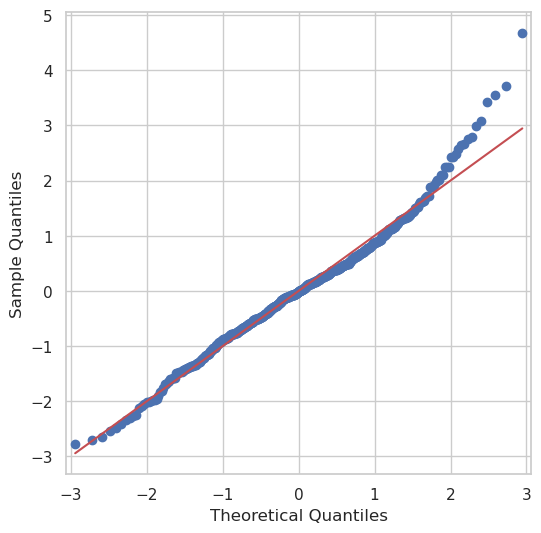

In [38]:
# qq plot of residuals
plt.rc("figure", figsize=(6, 6))
sm.qqplot(
    arima_results.resid,
    line="s",
    fit=True,
)
# resize the plot
plt.rc("figure", figsize=(16, 6))

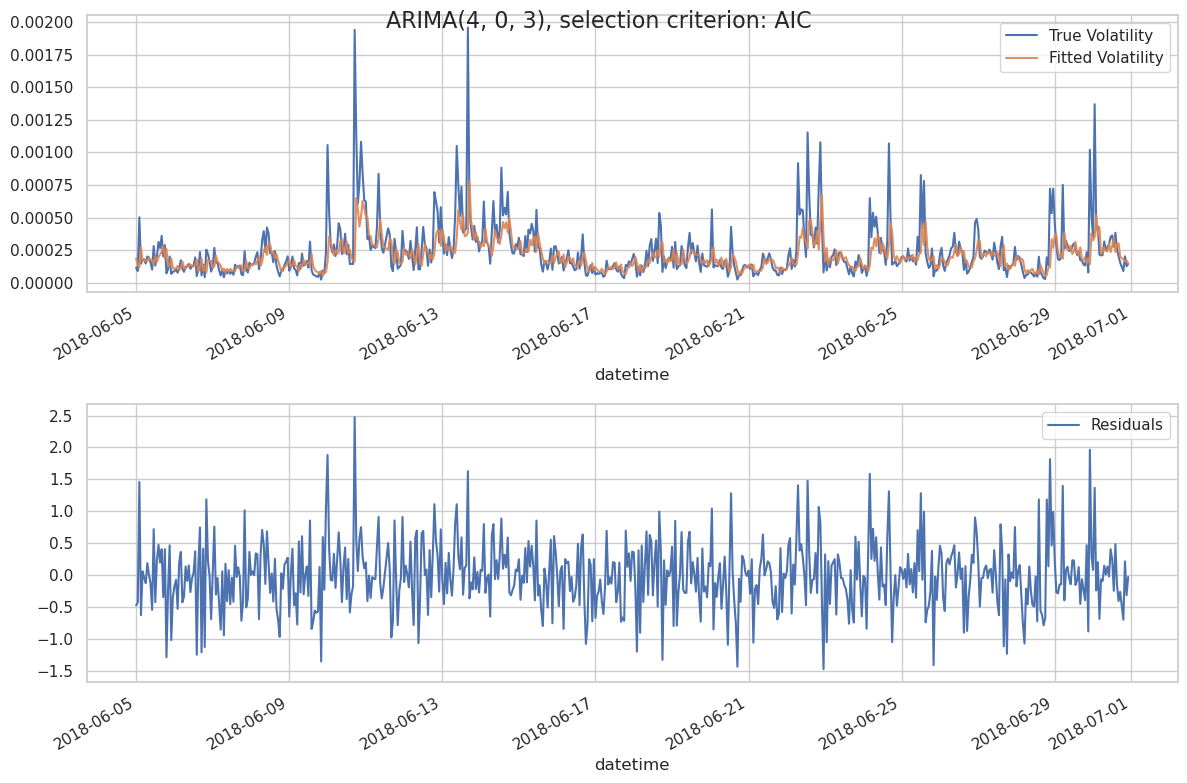

In [39]:
# plot, add residuals in a subplot
arima_results_df = pd.DataFrame(init_training_vola)
arima_results_df["residuals"] = arima_results.resid
arima_results_df["fitted"] = np.exp(arima_results.fittedvalues)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
arima_results_df["vol"].plot(ax=ax[0], label="True Volatility")
arima_results_df["fitted"].plot(ax=ax[0], label=f"Fitted Volatility", alpha=0.9)
ax[0].legend()
arima_results_df["residuals"].plot(ax=ax[1], label="Residuals")
plt.tight_layout()
ax[1].legend()
plt.suptitle(f"ARIMA({best_p}, 0, {best_q}), selection criterion: AIC", fontsize=16)
plt.show()

Text(0.5, 1.0, 'ARIMA(4,0,3) Residuals in log space')

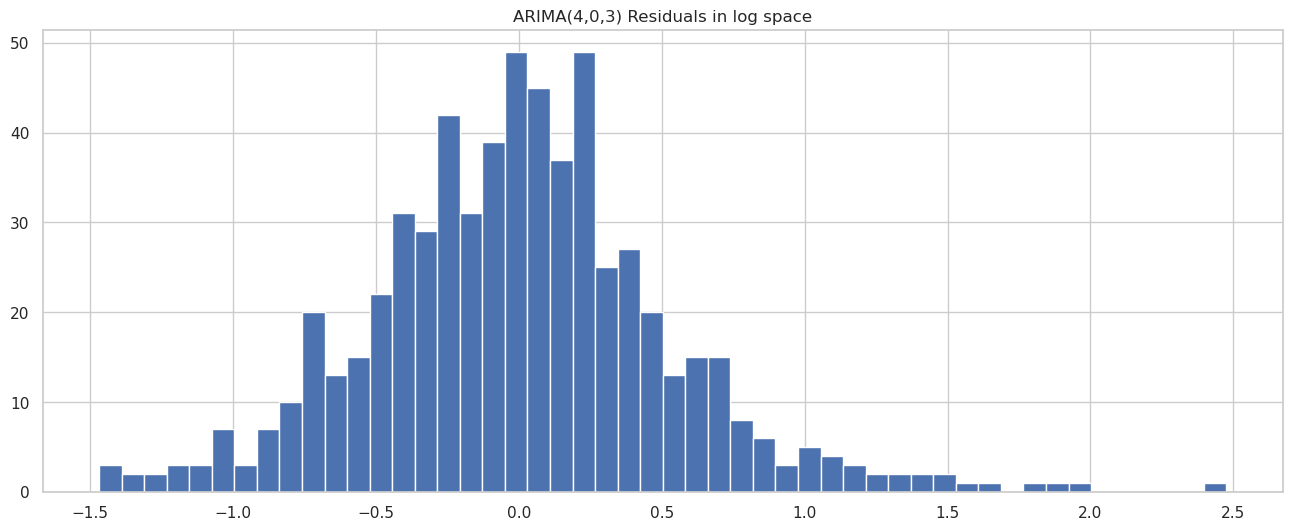

In [40]:
plt.hist(arima_results.resid, bins=50)
plt.title(f"ARIMA({best_p},0,{best_q}) Residuals in log space")

Text(0.5, 1.0, 'ARIMA(4,0,3) Residuals in the original space (not log)')

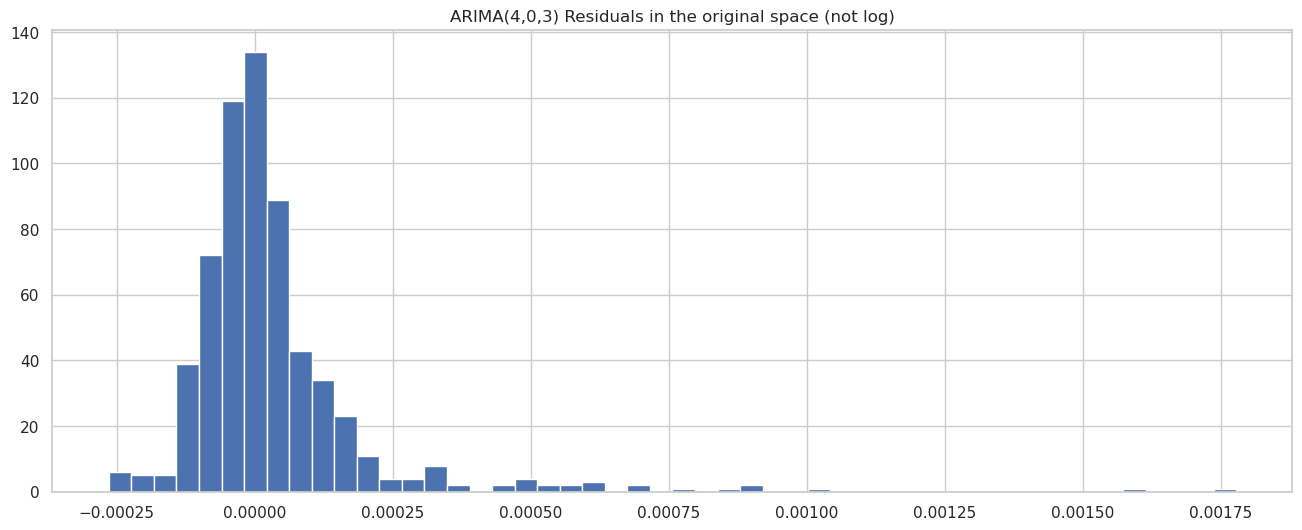

In [41]:
errors = arima_results_df.vol.values - np.exp(arima_results.fittedvalues)
plt.hist(errors, bins=50)
plt.title(f"ARIMA({best_p},0,{best_q}) Residuals in the original space (not log)")

In [42]:
bias_correction = arima_results_df.residuals.var()
print(f"Bias correction: {bias_correction:.6f}")

Bias correction: 0.281425


In [43]:
print(
    f"RMSE: {mse(arima_results_df.vol.values, np.exp(arima_results.fittedvalues) * np.exp(bias_correction / 2)) ** 0.5}"
)
print(f"MAE: {mae(arima_results_df.vol.values, np.exp(arima_results.fittedvalues))}")

RMSE: 0.00017564969127654488
MAE: 9.370643305244987e-05


Bias correction improves RMSE from 0.000178 to 0.000176

We will check optimal parameters with respect to BIC, as it penalizes the models with more parameters.

In [44]:
p_max = 5
q_max = 5
aic_p_q = find_p_q(
    init_training_vola.log_vol.values, max_p=p_max, max_q=q_max, criteria="bic"
)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Text(0.5, 54.249999999999986, 'q')

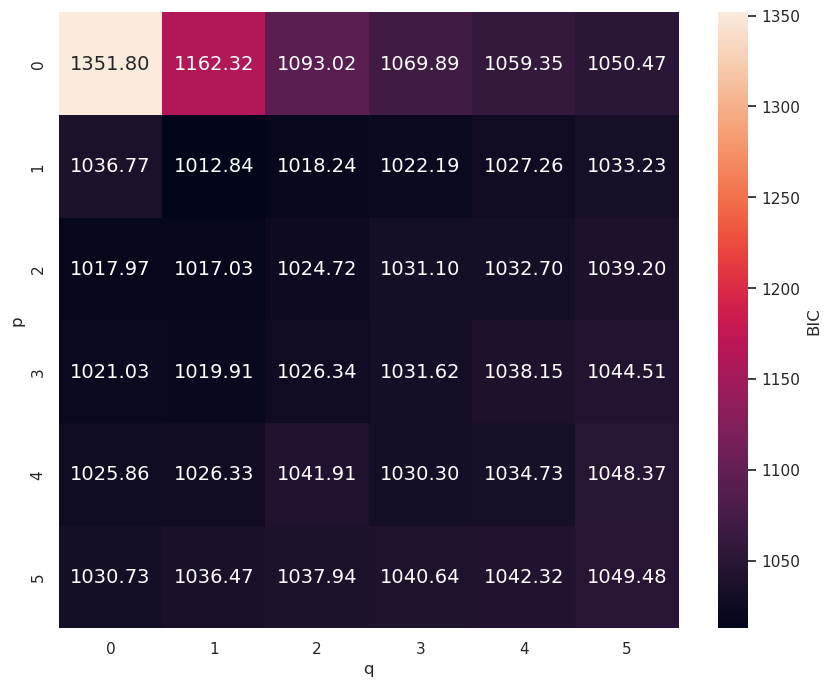

In [45]:
# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    aic_p_q.astype(float),
    annot=True,
    fmt=".2f",
    # cmap="YlGnBu",
    cbar_kws={"label": "BIC"},
)
plt.ylabel("p")
plt.xlabel("q")

In [46]:
# find the best p, q
best_p, best_q = np.unravel_index(np.argmin(aic_p_q.values), aic_p_q.shape)
print(f"Best p: {best_p}, Best q: {best_q}")
print(f"Best BIC: {aic_p_q.values[best_p, best_q]}")

Best p: 1, Best q: 1
Best BIC: 1012.839684339771


In [47]:
arima = ARIMA(
    endog=init_training_vola.log_vol.values,
    order=(best_p, 0, best_q),
)
arima_results = arima.fit(method_kwargs={"maxiter": 1000})
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  620
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -493.560
Date:                Sun, 29 Jun 2025   AIC                            995.121
Time:                        23:34:47   BIC                           1012.840
Sample:                             0   HQIC                          1002.008
                                - 620                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6032      0.087    -98.709      0.000      -8.774      -8.432
ar.L1          0.8369      0.032     26.075      0.000       0.774       0.900
ma.L1         -0.3598      0.054     -6.693      0.000      -0.465      -0.254
sigma2         0.2874      0.012     23.319      0.000       0.263       0.312
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               101.27
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.46
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
arima_results.mle_retvals

{'fopt': 0.7960651664738826,
 'gopt': array([-1.29307676e-07,  2.17825757e-07, -4.56101823e-07,  1.27420297e-07]),
 'fcalls': 65,
 'warnflag': 0,
 'converged': True,
 'iterations': 9}

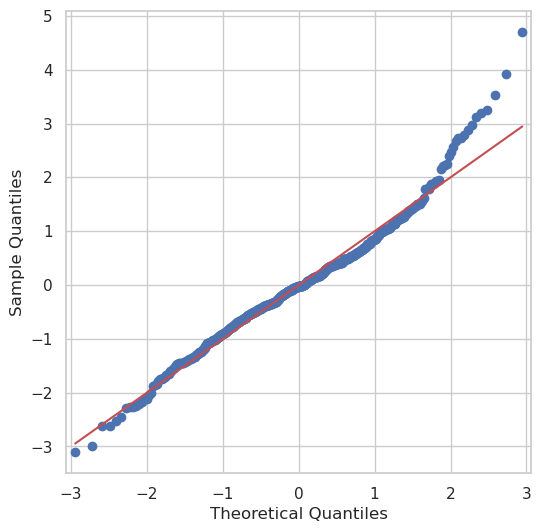

In [49]:
# qq plot of residuals
plt.rc("figure", figsize=(6, 6))
sm.qqplot(
    arima_results.resid,
    line="s",
    fit=True,
)
# resize the plot
plt.rc("figure", figsize=(16, 6))

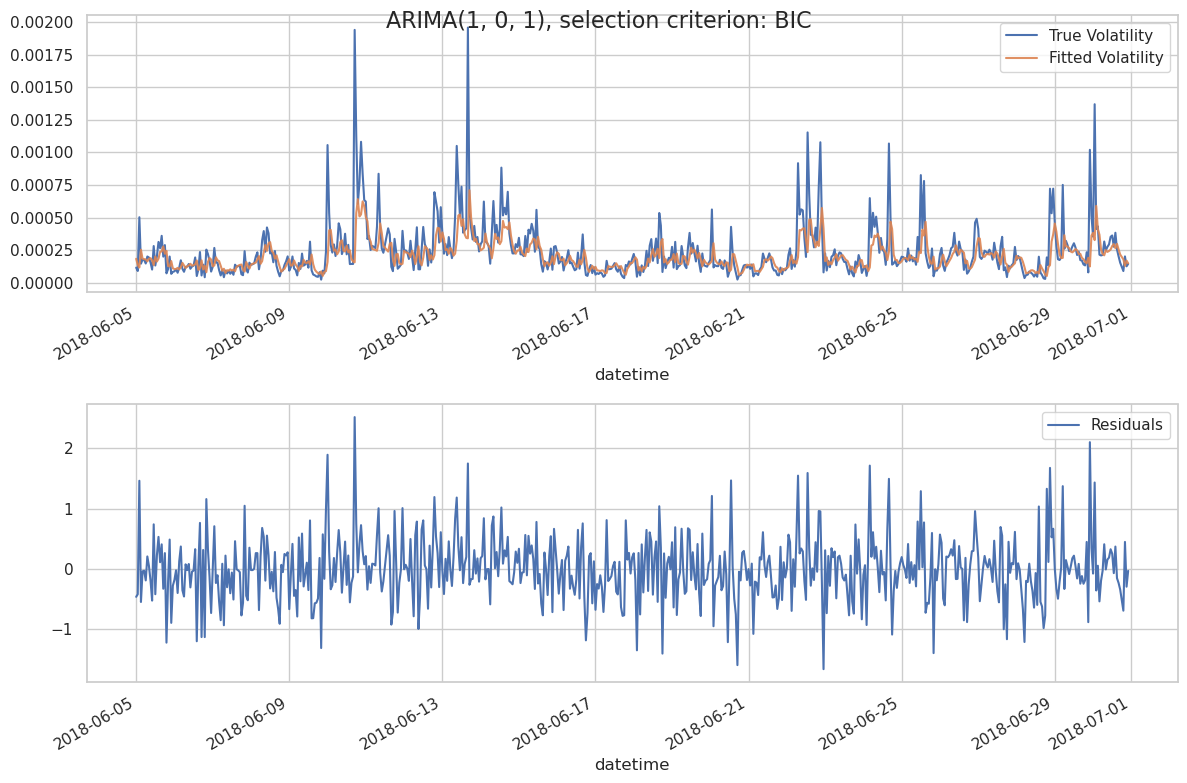

In [50]:
# plot, add residuals in a subplot
arima_results_df = pd.DataFrame(init_training_vola)
arima_results_df["residuals"] = arima_results.resid
arima_results_df["fitted"] = np.exp(arima_results.fittedvalues)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
arima_results_df["vol"].plot(ax=ax[0], label="True Volatility")
arima_results_df["fitted"].plot(ax=ax[0], label=f"Fitted Volatility", alpha=0.9)
ax[0].legend()
arima_results_df["residuals"].plot(ax=ax[1], label="Residuals")
plt.tight_layout()
ax[1].legend()
plt.suptitle(f"ARIMA({best_p}, 0, {best_q}), selection criterion: BIC", fontsize=16)
plt.show()

Text(0.5, 1.0, 'ARIMA(1,0,1) Residuals in log space')

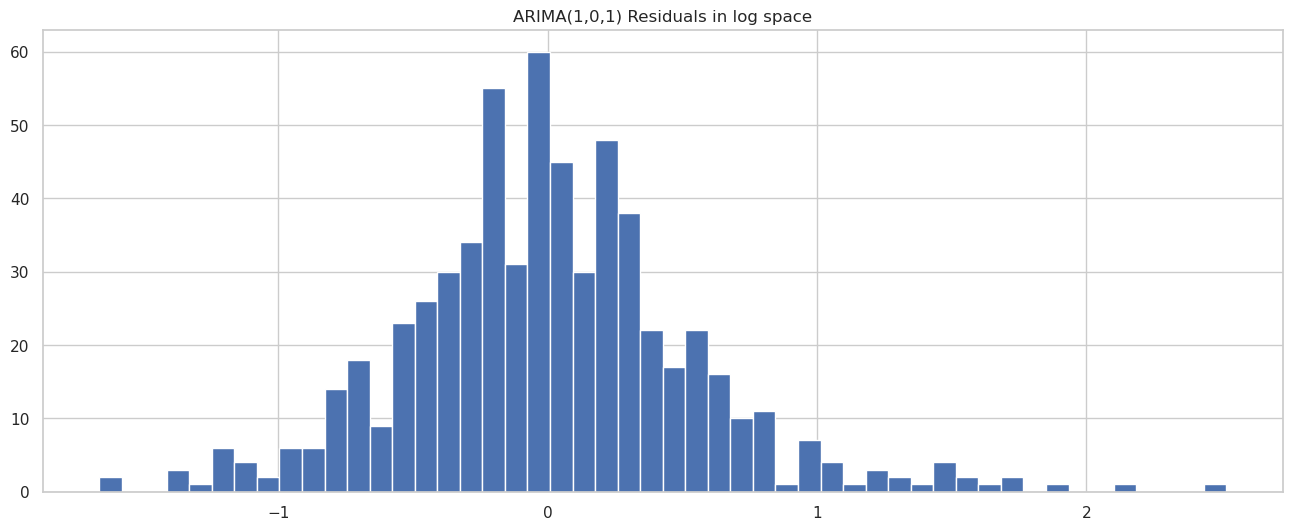

In [51]:
plt.hist(arima_results.resid, bins=50)
plt.title(f"ARIMA({best_p},0,{best_q}) Residuals in log space")

Text(0.5, 1.0, 'ARIMA(1,0,1) Residuals in the original space (not log)')

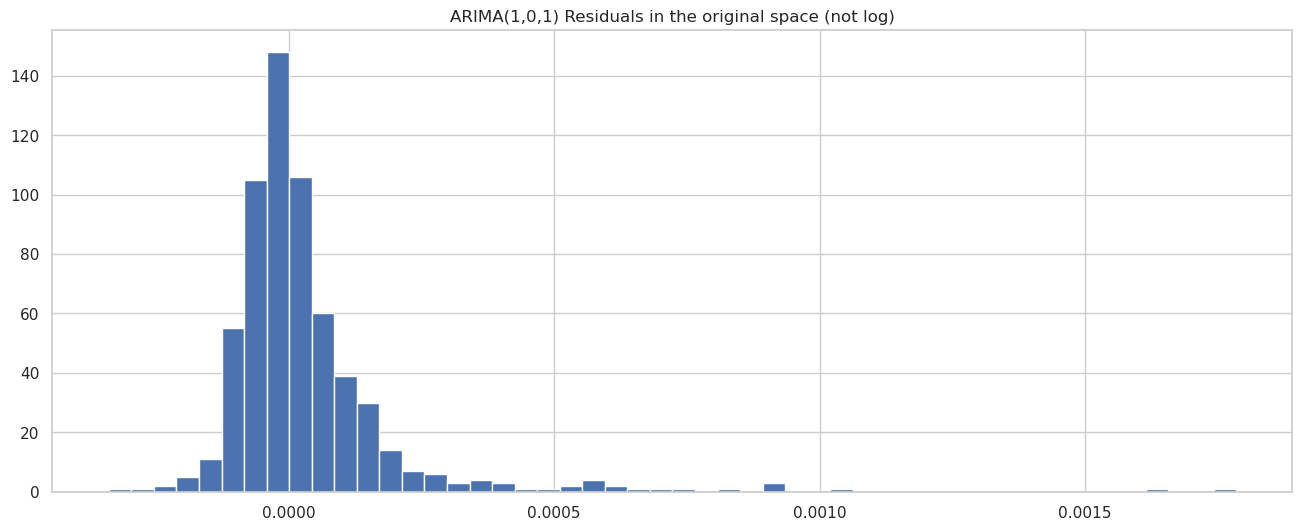

In [52]:
errors = arima_results_df.vol.values - np.exp(arima_results.fittedvalues)
plt.hist(errors, bins=50)
plt.title(f"ARIMA({best_p},0,{best_q}) Residuals in the original space (not log)")

In [53]:
bias_correction = arima_results_df.residuals.var()
print(f"Bias correction: {bias_correction:.6f}")

Bias correction: 0.288088


In [54]:
print(
    f"RMSE: {mse(arima_results_df.vol.values, np.exp(arima_results.fittedvalues) * np.exp(bias_correction / 2)) ** 0.5}"
)
print(f"MAE: {mae(arima_results_df.vol.values, np.exp(arima_results.fittedvalues))}")

RMSE: 0.00017725262917928422
MAE: 9.298513315901258e-05


ARIMA(4,0,3) achives about 1% better results in RMSE then to ARIMA(1,0,1), but 10% worst results in MAE, based on the in-sample analysis.

## Tuning parameters (p,q) in an Out-of-sample analysis

In [55]:
output_template = pd.DataFrame(
    index=validation_set.index, columns=["retraining_flag", "model_name"]
)
output_template.retraining_flag = False
output_template.loc[validation_set.index[0], "retraining_flag"] = True

In [56]:
backtester = BenchmarkBacktester(
    dataset=init_training_vola,
    output_template=output_template,
    last_train_date=validation_ts,
    is_training_expanded=True,
    lookback=pd.Timedelta(days=30),  # lookback window for the model
)

  0%|          | 0/142 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  4%|▍         | 6/142 [00:01<00:33,  4.02it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  478
Model:                 ARIMA(4, 0, 3)   Log Likelihood                -376.321
Date:                Sun, 29 Jun 2025   AIC                            770.643
Time:                        23:34:52   BIC                            808.169
Sample:                             0   HQIC                           785.396
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6235      0.150    -57.316      0.000      -8.918      -8.329
ar.L1          0.1675      0.302      0.554      0.579      -0.425       0.760
ar.L2          0.2771      0.272      1.021      0.3

100%|██████████| 142/142 [00:04<00:00, 32.76it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ARIMA
RMSE: 0.0001775
MAE:  0.0001079
Expanding training set: True
Test starting date: 2018-06-25 00:00:00
---------------------------------------------------


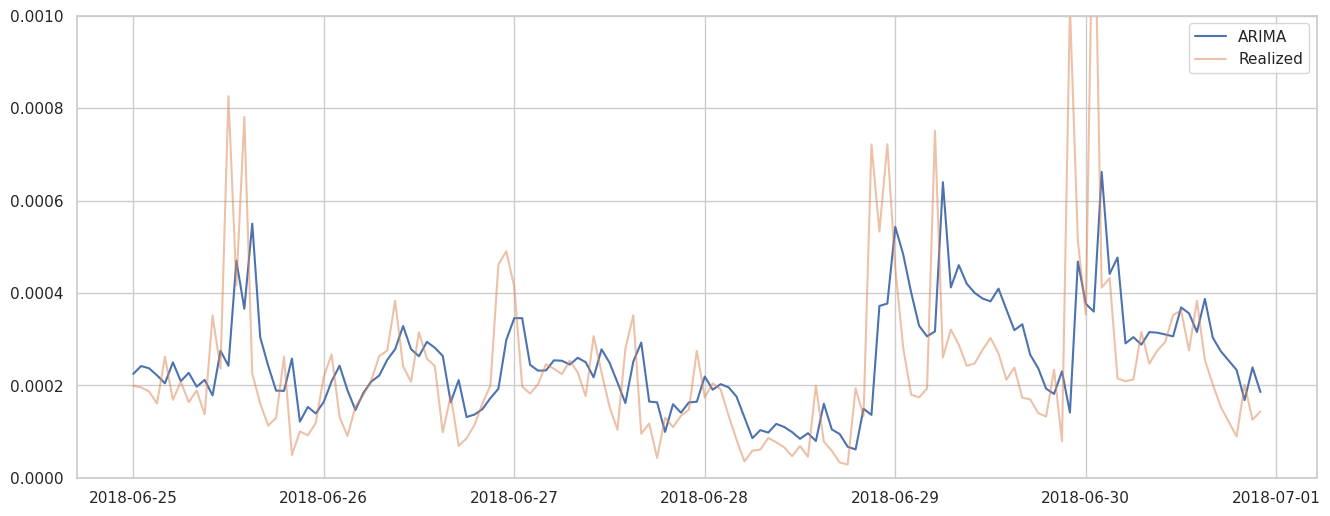

In [57]:
backtest_results_arima = backtester.backtest(
    ARIMAX, hyperparams={"p": 4, "d": 0, "q": 3}, use_ob_feats=False, use_log_y=True
)

  6%|▋         | 9/142 [00:00<00:05, 26.37it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  478
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -380.315
Date:                Sun, 29 Jun 2025   AIC                            768.629
Time:                        23:34:55   BIC                            785.308
Sample:                             0   HQIC                           775.186
                                - 478                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6136      0.109    -79.361      0.000      -8.826      -8.401
ar.L1          0.8669      0.033     26.622      0.000       0.803       0.931
ma.L1         -0.4210      0.057     -7.345      0.0

100%|██████████| 142/142 [00:02<00:00, 54.61it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ARIMA
RMSE: 0.0001766
MAE:  0.0001087
Expanding training set: True
Test starting date: 2018-06-25 00:00:00
---------------------------------------------------


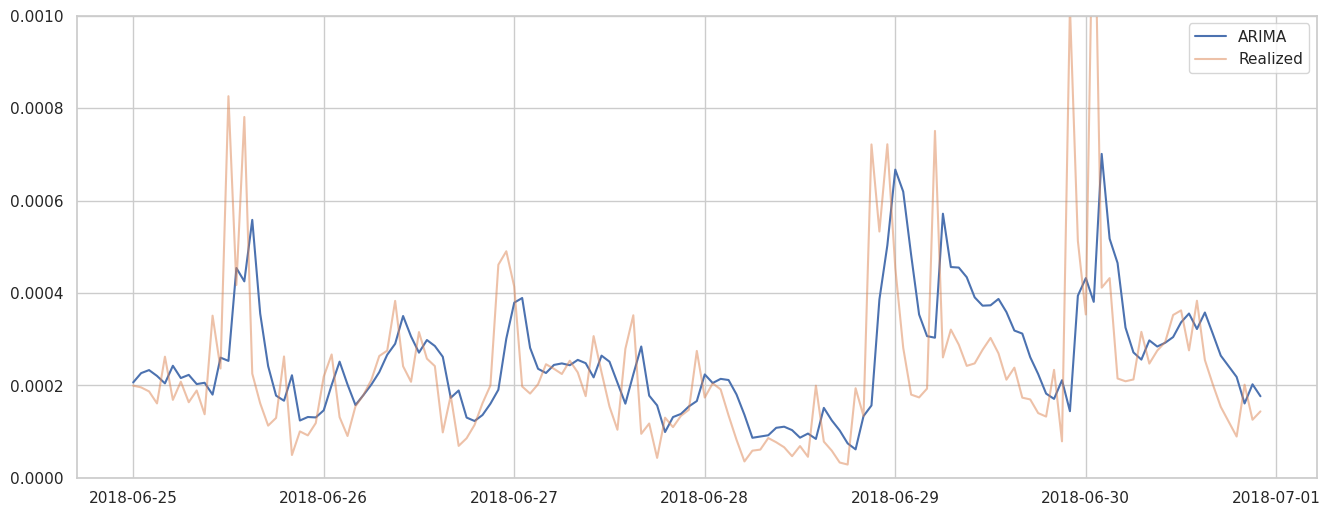

In [58]:
backtest_results_arima = backtester.backtest(
    ARIMAX, hyperparams={"p": 1, "d": 0, "q": 1}, use_ob_feats=False, use_log_y=True
)

## Conclusions

Based on the out-of-sample performance (small OOS), ARIMA(4,0,3) performs worse then ARIMA(1,0,1) in RMSE, but not in therms of MAE. The significance of these differences is not accessed. Therefore, we will use ARIMA(1,0,1) for the final model.

# GARCH(p,q)

In [59]:
from arch import arch_model

In [60]:
scale = 1.0

In [61]:
garch_init_training = (
    (
        pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
        .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
        .sort("datetime")
    )
    .select(["datetime", "vol", "ret", "ret_t-1"])
    .with_columns(
        ret=pl.col("ret") * scale,  # garch optimization works better when scaled
        # lagged_ret = pl.col("ret_t-1") * scale # garch optimization works better when scaled
    )
    .to_pandas()
    .set_index("datetime")
)

# drop NaN values
garch_init_training = garch_init_training.loc[:LAST_TRAINING_DATE].dropna()

# additionally split the init_training_vola into train and validation sets
garch_mini_training_set = garch_init_training.loc[
    : validation_ts - pd.Timedelta(hours=1), :
]
garch_validation_set = garch_init_training.loc[validation_ts:, :]

In [62]:
garch_model = arch_model(
    garch_init_training.ret.values,
    vol="Garch",
    p=1,
    o=0,
    q=1,
    dist="Normal",
    rescale=True,
)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3580.6370692099954
Iteration:      2,   Func. Count:     14,   Neg. LLF: 264665.92683164123
Iteration:      3,   Func. Count:     20,   Neg. LLF: 657.4740864010705
Iteration:      4,   Func. Count:     26,   Neg. LLF: 635.1843306017246
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2113.6489297074477
Iteration:      6,   Func. Count:     38,   Neg. LLF: 698.6058461684954
Iteration:      7,   Func. Count:     45,   Neg. LLF: 644.6235384598689
Iteration:      8,   Func. Count:     51,   Neg. LLF: 631.4009503175048
Iteration:      9,   Func. Count:     56,   Neg. LLF: 631.3936747117106
Iteration:     10,   Func. Count:     61,   Neg. LLF: 631.3851518215846
Iteration:     11,   Func. Count:     66,   Neg. LLF: 631.3837915156611
Iteration:     12,   Func. Count:     71,   Neg. LLF: 631.3835820454569
Iteration:     13,   Func. Count:     76,   Neg. LLF: 631.3835808002191
Iteration:     14,   Func. Count:     80,   Neg. LLF: 631.383

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -631.384
Distribution:                  Normal   AIC:                           1270.77
Method:            Maximum Likelihood   BIC:                           1288.49
                                        No. Observations:                  621
Date:                Sun, Jun 29 2025   Df Residuals:                      620
Time:                        23:34:59   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.9114e-03  3.635e-02      0.135      0.893 [-6.633e-02,7.615e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.2531  7.957e-02      3.181  1.467e-03    [9.716e-02,  0.409]
alpha[1]       0.9908      0.580      1.707  8.786e-02      [ -0.147,  2.129]
beta[1]    9.2241e-03  1.550e-02      0.595      0.552 [-2.115e-02,3.959e-02]
=============================================================================

Covariance estimator: robust
"""

**Note:** Non-significant $\beta$. Distribution of residuals is probably not normal, so let's test it.

In [63]:
jarque_bera(garch_results.resid)

(21184.502969855926, 0.0, 0.960051919804536, 31.548869569622518)

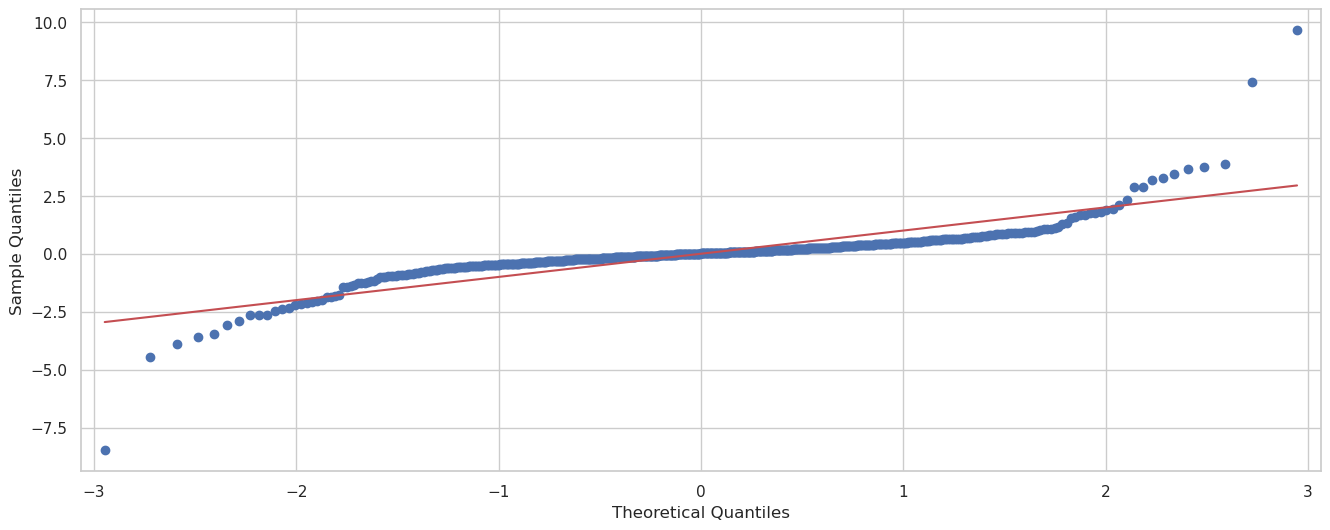

In [64]:
# qq plot of residuals
sm.qqplot(
    garch_results.resid,
    line="s",
    fit=True,
);

In [65]:
garch_results.scale

100.0

In [66]:
garch_results.forecast(horizon=1).variance.values

array([[0.25711523]])

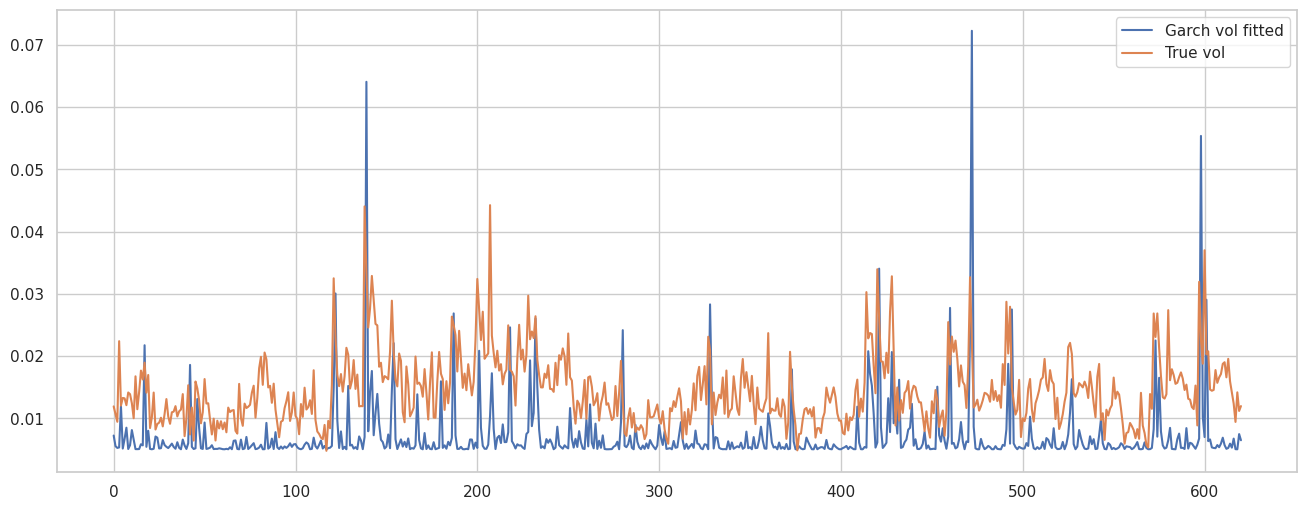

In [67]:
plt.plot(
    garch_results.conditional_volatility / garch_results.scale, label="Garch vol fitted"
)
plt.plot(np.sqrt(garch_init_training.vol.values), label="True vol")
plt.legend()
plt.show()

As we can see, GARCH(1,1) did not converge properly on the development set. We will see on the out-of-sample backtest that GARCH(1,1) sometimes does and sometimes does not converge properly. This is a known issue with GARCH models, especially on small datasets and when the data is not normally distributed.

Since the residuals are not normally distributed, we could use t-distribution instead of the normal distribution. However, this would not solve the convergence issue but even worsen it. Anyway, for the sake of completeness, we will try it.

In [68]:
garch_model = arch_model(
    garch_init_training.ret.values,
    vol="Garch",
    p=1,
    o=0,
    q=1,
    dist="studentst",
    rescale=True,
)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 16536.42567228248
Iteration:      2,   Func. Count:     16,   Neg. LLF: 8558.277127433736
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1792.7933066399733
Iteration:      4,   Func. Count:     30,   Neg. LLF: 8515.57265952906
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1269.4558274269286
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1171.5290545682114
Iteration:      7,   Func. Count:     51,   Neg. LLF: 812.4799844624857
Iteration:      8,   Func. Count:     58,   Neg. LLF: 760.8930119087374
Iteration:      9,   Func. Count:     65,   Neg. LLF: 737.4872791723072
Iteration:     10,   Func. Count:     72,   Neg. LLF: 721.0340521059913
Iteration:     11,   Func. Count:     79,   Neg. LLF: 706.053330671796
Iteration:     12,   Func. Count:     86,   Neg. LLF: 695.8510272175831
Iteration:     13,   Func. Count:     93,   Neg. LLF: 577.0403731847207
Iteration:     14,   Func. Count:    100,   Neg. LLF: 420.87477

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -412.603
Distribution:      Standardized Student's t   AIC:                           835.206
Method:                  Maximum Likelihood   BIC:                           857.363
                                              No. Observations:                  621
Date:                      Sun, Jun 29 2025   Df Residuals:                      620
Time:                              23:35:00   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0148  1.262e-02     -1.176      0.240 [-3.958e-02,9.894e-03]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5244      0.171      3.058  2.230e-03    [  0.188,  0.861]
alpha[1]       0.9571      0.312      3.069  2.149e-03    [  0.346,  1.568]
beta[1]        0.0429  6.543e-02      0.656      0.512 [-8.531e-02,  0.171]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.2244  6.982e-02     31.861 9.382e-223 [  2.088,  2.361]
========================================================================

Covariance estimator: robust
"""

We will fit GARCH(1,1) with skewed t-distribution, to check if adding skewness improves the model. 
This is not very kosher way to decide whether to use skewed t-distribution or not - a better way would be to use formal tests.

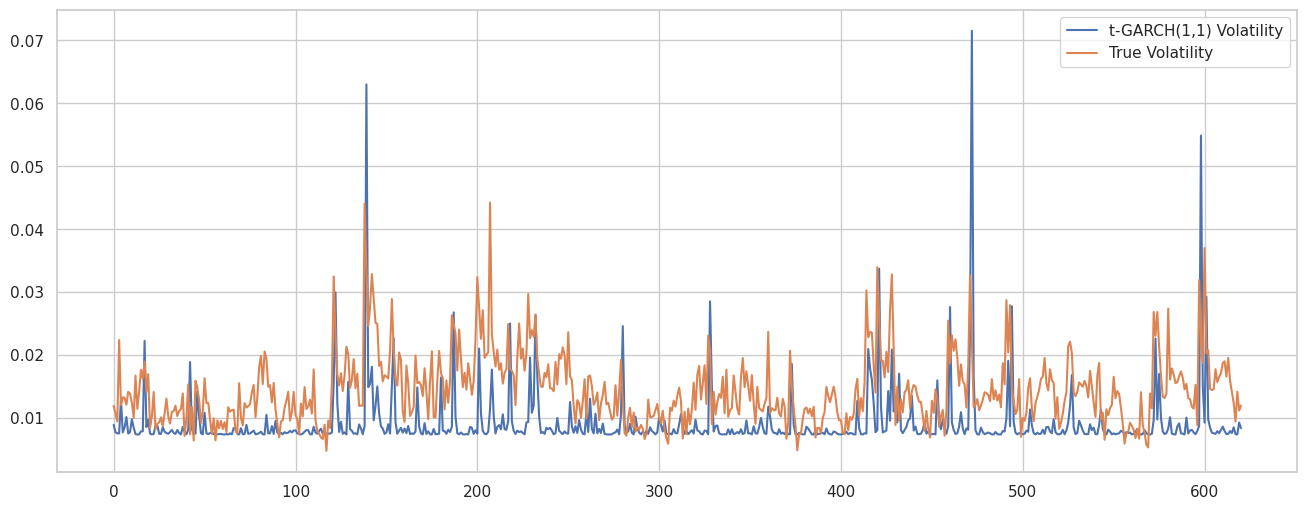

In [69]:
plt.plot(
    garch_results.conditional_volatility / garch_results.scale,
    label="t-GARCH(1,1) Volatility",
)
plt.plot(np.sqrt(garch_init_training.vol.values), label="True Volatility")
plt.legend()

As we can see, the model did not converge properly.

In [70]:
garch_model = arch_model(
    garch_init_training.ret.values,
    vol="Garch",
    p=1,
    o=0,
    q=1,
    # mean='Zero',
    dist="skewstudent",
    rescale=True,
)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 16340.521365491237
Iteration:      2,   Func. Count:     18,   Neg. LLF: 52071.49511434992
Iteration:      3,   Func. Count:     26,   Neg. LLF: 14492.147886060528
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1754.659979051917
Iteration:      5,   Func. Count:     42,   Neg. LLF: 9645.09514105351
Iteration:      6,   Func. Count:     50,   Neg. LLF: 1427.310685018789
Iteration:      7,   Func. Count:     58,   Neg. LLF: 767.805402897894
Iteration:      8,   Func. Count:     66,   Neg. LLF: 755.4961380824126
Iteration:      9,   Func. Count:     74,   Neg. LLF: 735.9608924382909
Iteration:     10,   Func. Count:     82,   Neg. LLF: 738.807432553343
Iteration:     11,   Func. Count:     90,   Neg. LLF: 715.8859591458533
Iteration:     12,   Func. Count:     98,   Neg. LLF: 741.5196295671348
Iteration:     13,   Func. Count:    106,   Neg. LLF: 419.8200360399889
Iteration:     14,   Func. Count:    114,   Neg. LLF: 417.9985504

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                                 y   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -412.303
Distribution:      Standardized Skew Student's t   AIC:                           836.606
Method:                       Maximum Likelihood   BIC:                           863.194
                                                   No. Observations:                  621
Date:                           Sun, Jun 29 2025   Df Residuals:                      620
Time:                                   23:35:01   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0249  1.774e-02     -1.405      0.160 [-5.970e-02,9.846e-03]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.5327      0.175      3.042  2.352e-03    [  0.189,  0.876]
alpha[1]       0.9555      0.315      3.036  2.399e-03    [  0.339,  1.572]
beta[1]        0.0445  6.722e-02      0.662      0.508 [-8.725e-02,  0.176]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
eta            2.2210  6.928e-02     32.058 1.701e-225   [  2.085,  2.357]
lambda        -0.0350  4.287e-02     -0.817      0.414 [ -0.119,4.902e-02]
==========================================================================

Covariance estimator: robust
"""

**Note:** Non-significant skew parameter. We can work with symmetric t-distribution.

So far, choosing GARCH(1,1) instead of any other model (in terms of orders of p and q) is a bit arbitrary, but in line with the common practice. We will check if other choices of (p,q) are better. 

In [71]:
# Determines the p and q that minimizes the AIC
def find_p_q_garch(ts, max_p, max_q, o, dist="Normal"):
    p_q_table = pd.DataFrame(
        index=range(1, max_p + 1), columns=range(max_q + 1)
    )  # p starts from 1
    for p in range(1, max_p + 1):
        for q in range(max_q + 1):
            model = arch_model(ts, vol="Garch", p=p, o=o, q=q, dist=dist, rescale=True)
            garch_results = model.fit()
            p_q_table.loc[p, q] = garch_results.aic

    # plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        p_q_table.astype(float),
        annot=True,
        fmt=".2f",
        # cmap="YlGnBu",
        cbar_kws={"label": "AIC"},
    )
    # add axis labels
    plt.title(f"AIC of GARCH(p,o={o},q) models")
    plt.xlabel("q")
    plt.ylabel("p")
    plt.show()

    return p_q_table


# Plots the residuals including their density
def plot_residuals(model):
    resids = model.resid[1:]
    fig, ax = plt.subplots(1, 2)
    resids.plot(title="Residuals", ax=ax[0])
    resids.plot(title="Density", kind="kde", ax=ax[1])
    plt.show()

In [72]:
p_max = 5
q_max = 5
o_fixed = 0

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17406.48346544515
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8528.875168892457
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1752.456462144243
Iteration:      4,   Func. Count:     27,   Neg. LLF: 991.0432014306842
Iteration:      5,   Func. Count:     33,   Neg. LLF: 817.7572935624237
Iteration:      6,   Func. Count:     39,   Neg. LLF: 781.7431779445285
Iteration:      7,   Func. Count:     45,   Neg. LLF: 761.6879883802436
Iteration:      8,   Func. Count:     51,   Neg. LLF: 747.1365820466297
Iteration:      9,   Func. Count:     57,   Neg. LLF: 734.411045861532
Iteration:     10,   Func. Count:     63,   Neg. LLF: 727.3450705219956
Iteration:     11,   Func. Count:     69,   Neg. LLF: 481.74985958836936
Iteration:     12,   Func. Count:     75,   Neg. LLF: 726.73561614255
Iteration:     13,   Func. Count:     81,   Neg. LLF: 422.28355615984094
Iteration:     14,   Func. Count:     87,   Neg. LLF: 418.0895261

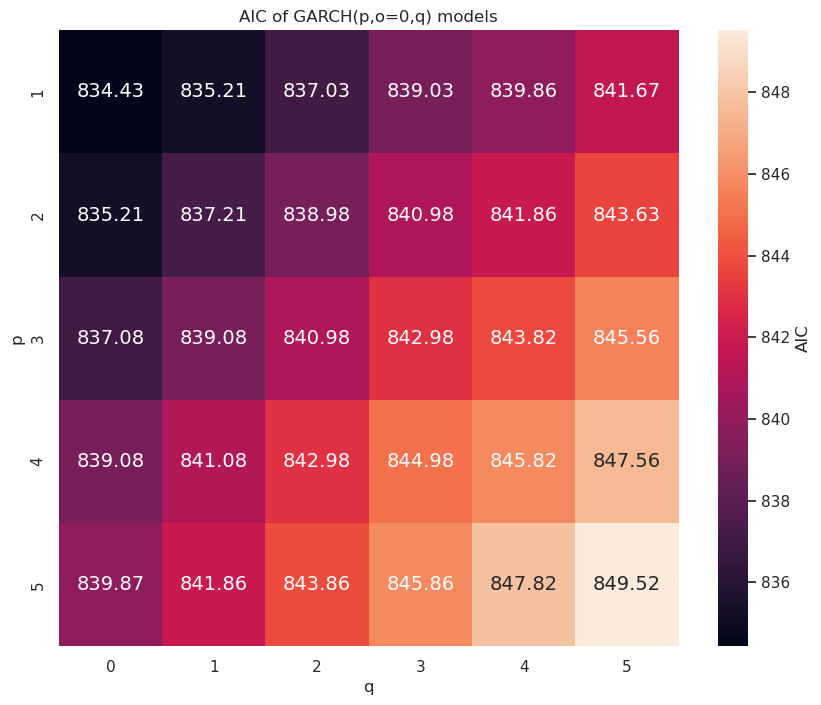

In [73]:
aic_p_q = find_p_q_garch(
    garch_init_training.ret.values,
    max_p=p_max,
    max_q=q_max,
    o=o_fixed,
    dist="studentst",
)

In [74]:
# find the best p, q
best_p, best_q = np.unravel_index(np.argmin(aic_p_q.values), aic_p_q.shape)
best_p = best_p + 1  # add 1 because we start from 1
best_p = int(best_p)
best_q = int(best_q)
print(f"Best p: {best_p}, o={o_fixed},  Best q: {best_q}")
print(f"Best AIC: {aic_p_q.values[best_p, best_q]}")

Best p: 1, o=0,  Best q: 0
Best AIC: 835.2149302778271


In [75]:
garch_model = arch_model(
    garch_init_training.ret.values,
    vol="Garch",
    p=1,
    o=0,
    q=0,
    dist="studentst",
    rescale=True,
)
garch_results = garch_model.fit()
garch_results.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17406.48346544515
Iteration:      2,   Func. Count:     15,   Neg. LLF: 8528.875168892457
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1752.456462144243
Iteration:      4,   Func. Count:     27,   Neg. LLF: 991.0432014306842
Iteration:      5,   Func. Count:     33,   Neg. LLF: 817.7572935624237
Iteration:      6,   Func. Count:     39,   Neg. LLF: 781.7431779445285
Iteration:      7,   Func. Count:     45,   Neg. LLF: 761.6879883802436
Iteration:      8,   Func. Count:     51,   Neg. LLF: 747.1365820466297
Iteration:      9,   Func. Count:     57,   Neg. LLF: 734.411045861532
Iteration:     10,   Func. Count:     63,   Neg. LLF: 727.3450705219956
Iteration:     11,   Func. Count:     69,   Neg. LLF: 481.74985958836936
Iteration:     12,   Func. Count:     75,   Neg. LLF: 726.73561614255
Iteration:     13,   Func. Count:     81,   Neg. LLF: 422.28355615984094
Iteration:     14,   Func. Count:     87,   Neg. LLF: 418.0895261

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - ARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -413.216
Distribution:      Standardized Student's t   AIC:                           834.432
Method:                  Maximum Likelihood   BIC:                           852.157
                                              No. Observations:                  621
Date:                      Sun, Jun 29 2025   Df Residuals:                      620
Time:                              23:35:09   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0155  1.259e-02     -1.230      0.219 [-4.016e-02,9.183e-03]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5774      0.188      3.078  2.084e-03 [  0.210,  0.945]
alpha[1]       1.0000      0.320      3.124  1.786e-03 [  0.373,  1.627]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.2169  6.665e-02     33.260 1.464e-242 [  2.086,  2.348]
========================================================================

Covariance estimator: robust
"""

## Conclusions

GARCH(1,1) has convergences issues on the development set. This is probably due to small training sample rather then misspecification of the distribution of the innovations: recall that switching from normal to t-dist did not change much the values of the fitted coefficients.

GARCH(1,0) is very similar to GARCH(1,1) in terms of AIC and coefficients fitted. Given that it also has convergence issues, as well as other more complex modifications of GARCH, we can't make reliable comparisons between different versions of the model. Thus, **we will use t-GARCH(1,1)** as returns on this timescales are very highly leptokurtic, and **GARCH(1,1)**, as we expect it to have less problems with convergence on the backtest. 

# HAR

The dependent variable (integrated volatility) is distributed as a log-normal. But, observations in the tails of the distributions are expected to have lower predictability. Instances of extremely high volatility are commonly due to external shocks (such as good or bad news), which we do not expect to be predictable using the past volatility, and maybe somewhat predictable based on the OB features. Thus, we want to penalize the model less for the errors made on the tail with large volatility, and penalize more for the errors made in times of low volatility.

## Prepare features

In [76]:
full_data = (
    (
        pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
        .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
        .sort("datetime")
    )
    .to_pandas()
    .set_index("datetime")
)

NUM_LAGS = 1

for i in range(1, NUM_LAGS + 1):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log volatilitiess
full_data["log_vol"] = np.log(full_data["vol"])
for i in range(1, NUM_LAGS + 1):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)

full_data.loc[:, ["log_volume"]] = np.log(full_data.loc[:, "volume"] + 0.0000001)

raw_features_names = [
    "spread",
    # "ask_depth", # = const
    "bid_depth",
    # "depth_diff", # = bid_depth - ask_depth(const)
    "ask_volume",
    # "bid_volume", # eliminated in the features engineering stage
    # "volume_diff", # = bid_volume - ask_volume (redundant in linear models)
    # "weighted_spread", #  eliminated in the features engineering stage, no correlation with volatility
    "ask_slope",
    # "bid_slope" # eliminated in the features engineering stage, very correlated with ask_slope
]

selected_ob_features = [
    "mean_spread",
    "mean_bid_depth",
    "mean_ask_volume",
    "iq_range_bid_depth",
    "iq_range_ask_volume",
    "iq_range_ask_slope",
]


for col in raw_features_names:
    columns_to_use = full_data.columns[full_data.columns.str.startswith(col)]
    # sort columns by the time delta, e.g. "bid_volume_t-1", "bid_volume_t-2", ..., "bid_volume_t-60"
    columns_to_use = sorted(columns_to_use, key=lambda x: int(x.split("_t-")[-1]))

    full_data[f"mean_{col}"] = full_data.loc[
        :, full_data.columns.str.startswith(col)
    ].mean(axis=1)
    full_data[f"iq_range_{col}"] = np.log(
        0.0001
        + (
            full_data.loc[:, columns_to_use[:]].quantile(0.75, axis=1)
            - full_data.loc[:, columns_to_use[:]].quantile(0.25, axis=1)
        )
        / full_data.loc[:, columns_to_use[:]].median(axis=1)
    )

# moving average of log_vol_lag1. These are the main features of HAR model
LAGS = [1, 6, 24]
for lag in LAGS:
    full_data.loc[:, f"log_vol_lag1_smooth{lag}"] = (
        full_data.loc[:, "log_vol_lag1"].rolling(window=lag).mean()
    )

dataset = full_data.dropna().loc[
    :,
    # RESPONSE
    # ['vol', 'ret', 'log_vol'] +
    ["log_vol"]
    +
    # FEATURES
    # [f'vol_lag{i}' for i in range(1,NUM_LAGS+1)] +
    # [f'log_vol_lag{i}' for i in range(1,NUM_LAGS+1)] +
    [f"log_vol_lag1_smooth{lag}" for lag in LAGS]
    + ["log_volume"]
    + selected_ob_features,
]

LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

In [77]:
y = init_training_vola.loc[:, "log_vol"]
y

datetime
2018-06-05 23:00:00   -9.395672
2018-06-06 00:00:00   -9.348389
2018-06-06 01:00:00   -9.185994
2018-06-06 02:00:00   -9.482964
2018-06-06 03:00:00   -9.069514
                         ...   
2018-06-30 17:00:00   -8.781391
2018-06-30 19:00:00   -9.323500
2018-06-30 20:00:00   -8.509267
2018-06-30 21:00:00   -8.981984
2018-06-30 22:00:00   -8.847212
Name: log_vol, Length: 597, dtype: float64

In [78]:
X = init_training_vola.loc[:, init_training_vola.columns != "log_vol"]
X

,log_vol_lag1_smooth1,log_vol_lag1_smooth6,log_vol_lag1_smooth24,log_volume,mean_spread,mean_bid_depth,mean_ask_volume,iq_range_bid_depth,iq_range_ask_volume,iq_range_ask_slope
datetime,,,,,,,,,,
2018-06-05 23:00:00,-9.600540,-8.916600,-8.673882,4.595965,4.339000,2854.916667,2242.934275,-6.118582,-5.075595,-7.587819
2018-06-06 00:00:00,-9.395672,-9.063109,-8.696391,4.041086,4.669583,2860.983333,2280.225762,-7.132079,-4.212557,-6.813087
2018-06-06 01:00:00,-9.348389,-9.262724,-8.708069,4.735400,5.221000,2862.116667,2276.860574,-6.769863,-4.158290,-6.831365
2018-06-06 02:00:00,-9.185994,-9.203051,-8.702541,5.327580,4.654083,2860.375000,2315.646031,-5.972286,-4.296181,-7.102543
2018-06-06 03:00:00,-9.482964,-9.254608,-8.781163,4.499403,4.913000,2858.625000,2342.686001,-7.131467,-5.036392,-6.521619
...,...,...,...,...,...,...,...,...,...,...
2018-06-30 17:00:00,-8.506554,-8.119574,-8.151021,5.782078,6.176167,2557.083333,2092.303235,-5.864425,-4.500541,-6.237834
2018-06-30 19:00:00,-8.781391,-8.258015,-8.155170,5.203841,5.389583,2565.350000,2108.711393,-6.401999,-4.865156,-6.350521
2018-06-30 20:00:00,-9.323500,-8.491464,-8.173920,5.369528,3.821000,2574.766667,2105.123597,-5.871944,-4.938087,-6.746690


## Compute weights

The following is the candidate function for the weights of the HAR model:
$$
w_t = \frac{1}{\varepsilon + vola_t}
$$
where $\varepsilon$ is a small constant, e.g. 0.001, and $vola_t$ is the volatility (not log-vola) at time $t$.

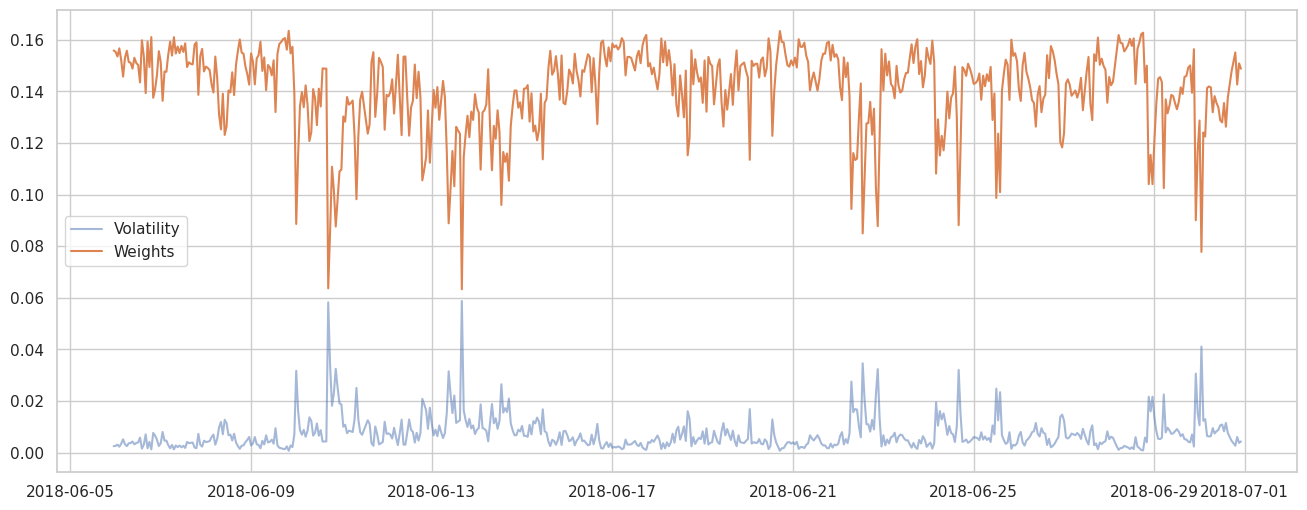

In [79]:
weights = 1 / (0.0012 + np.exp(y.values))
plt.plot(30 * np.exp(y), label="Volatility", alpha=0.5)
plt.plot(y.index, weights / 5000, label="Weights")
plt.legend()

The following looks stable around "calm" periods, and has about 2-3 times difference between the weights in "calm" and peaks periods. The difference is changed by the choice of $\varepsilon$. We choose this one as a compromise between making stable weights in "calm" periods and making the difference between the weights in "calm" and peaks periods large enough to make for a non-trivial weighting scheme. We determine the value of $\varepsilon$ by visual inspection of the weights plot above and manual tuning.

Downside of the chosen weights is that it puts less weights in hight volatility. What we really need is low weights on sudden jumps in volatility, not necessarily high volatility per se.

We can do compute this by computing relative change in volatility and then labeling highest 10% of the relative changes as "jumps" and assigning them a low weight, for example 0.1, and the rest a weight of 1.

$$
w_t = \begin{cases}
1 & \text{if } \frac{vola_t - vola_{t-1}}{vola_{t-1}} < c \\
0.1 & \text{if } \frac{vola_t - vola_{t-1}}{vola_{t-1}} \geq c
\end{cases}
$$
where $c = \text{quantile}_{0.90} \big(\frac{vola_t - vola_{t-1}}{vola_{t-1}}; t \in [T] \big)$

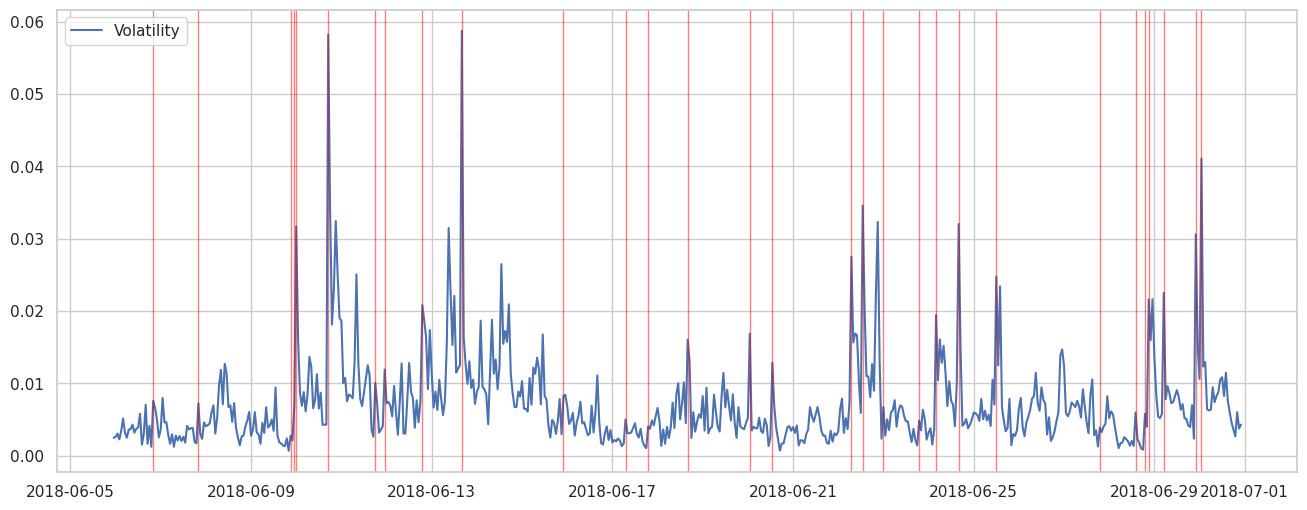

In [80]:
rel_changes = np.exp(y).pct_change()
rel_changes = rel_changes.fillna(0)
c = np.quantile(rel_changes, 0.95)
weights = np.where(rel_changes < c, 1.0, 0.0)
plt.plot(30 * np.exp(y), label="Volatility", alpha=1)
# plt.plot(y.index, weights/100 - 0.01, label='Weights')

# vertical lines where weights are 0
for i in range(len(weights)):
    if weights[i] == 0:
        plt.axvline(x=y.index[i], color="red", alpha=0.5, linewidth=1)
plt.legend()

It does not seem like this heuristics is very useful in picking "jumps" in volatility. We will skip this one, and use the first method.

In [81]:
from vol_predict.models.abstract_benchmark import AbstractBenchmark

# from scipy.optimize import least_squares
# from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


class HAR(AbstractBenchmark):
    """ """

    def __init__(
        self,
        lags: list = [1, 6, 24],  # lags for HAR model
        l2: float = 70.0,  # shrinkage parameter, l2 regularization parameter
        is_weighted: bool = False,  # whether to weight points by the inverse of the vola
        use_ob_feats: bool = False,
        use_log_y: bool = True,
        *args,
        **kwargs,
    ):
        self.lags = lags
        self.l2 = l2
        self.is_weighted = is_weighted
        self.use_ob_feats = use_ob_feats
        self.use_log_y = use_log_y
        self.label_name = "log_vol" if use_log_y else "vol"
        self.name = "HARX" if use_ob_feats else "HAR"

        if self.use_log_y:
            self.ma_features = [f"log_vol_lag1_smooth{lag}" for lag in self.lags]
        else:
            self.ma_features = [f"vol_lag1_smooth{lag}" for lag in self.lags]

        if use_ob_feats:
            self.ob_features = [
                "log_volume",
                "mean_spread",
                "mean_bid_depth",
                "mean_ask_volume",
                "iq_range_bid_depth",
                "iq_range_ask_volume",
                "iq_range_ask_slope",
            ]
            self.feature_names = self.ma_features + self.ob_features
        else:
            self.ob_features = []
            self.feature_names = self.ma_features

        self.results = None

    def fit(self, y: pd.Series, X: pd.DataFrame):
        """ """

        X = X.loc[:, self.feature_names]

        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)

        X = sm.add_constant(X, has_constant="skip")

        if self.is_weighted:
            if self.use_log_y:
                weights = 1 / (0.0012 + np.exp(y.values))
            else:
                weights = 1 / (0.0012 + y.values)
        else:
            weights = np.ones(y.shape[0])

        # scale by sample size to make shrinkage uniform across different sample sizes
        normalized_weights = y.values.shape[0] * (weights / (weights.sum()))
        W = np.diag(normalized_weights)

        ######
        ######
        ######
        #        HERE we shrink the past volatility coefficients
        ######
        ######
        ######
        LambdaMat = self.l2 * np.diag(
            [1] * (1 + len(self.lags)) + [1] * (len(self.ob_features))
        )

        self.beta = np.linalg.inv(X.T @ (W @ X) + LambdaMat) @ (X.T @ (W @ y.values))
        self.results = self.beta

    def forecast(self, steps: int = 1, X: pd.DataFrame = None):
        """
        Forecast the next steps volatility.
        """
        if self.results is None:
            raise ValueError("Model not fitted yet. Please fit the model first.")

        X = X.loc[
            :, self.feature_names
        ]  # .iloc[-1:]  # take the last row for forecasting

        X = self.scaler.transform(X)

        # for a single observation we need `has_constant='add'`
        X = sm.add_constant(X, has_constant="add")

        if self.use_log_y:
            return np.array(np.exp(X @ self.beta))
        else:
            return np.array(X @ self.beta)

    def update(self, new_y: pd.Series, new_X: pd.DataFrame):
        """
        Update the model with new data.
        """
        pass  # not needed for this model

## Cross-validation

### Non-weighted estimation with Shrinkage

In [82]:
har = HAR(
    lags=[1, 6, 24],
    l2=70.0,
    is_weighted=True,
    use_ob_feats=False,  #!!!!!!!! UNIVARIATE HAR MODEL
    use_log_y=True,
)

In [83]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

kf = KFold(n_splits=5, shuffle=False)

results = []

for lambda_ in [0] + np.logspace(-2, 2, num=10).tolist():
    har.l2 = lambda_
    print(f"Fitting HAR model with l2={har.l2}")
    for train_index, test_index in kf.split(init_training_vola):
        train_data = init_training_vola.iloc[train_index]
        test_data = init_training_vola.iloc[test_index]

        y_train = train_data.loc[:, har.label_name]
        X_train = train_data.loc[:, train_data.columns != har.label_name]

        har.fit(y_train, X_train)

        y_test = test_data.loc[:, har.label_name]
        X_test = test_data.loc[:, test_data.columns != har.label_name]

        predictions = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            predictions[i] = har.forecast(steps=1, X=X_test.iloc[[i], :]) * np.exp(
                y_train.var() / 2
            )  # bias correction

        rmse = mse(np.exp(y_test.values), predictions) ** 0.5
        mae_res = mae(np.exp(y_test.values), predictions)

        results.append({"rmse": rmse, "mae": mae_res, "l2": har.l2})

Fitting HAR model with l2=0
Fitting HAR model with l2=0.01
Fitting HAR model with l2=0.027825594022071243
Fitting HAR model with l2=0.0774263682681127
Fitting HAR model with l2=0.21544346900318834
Fitting HAR model with l2=0.5994842503189409
Fitting HAR model with l2=1.6681005372000592
Fitting HAR model with l2=4.6415888336127775
Fitting HAR model with l2=12.915496650148826
Fitting HAR model with l2=35.93813663804626
Fitting HAR model with l2=100.0


In [84]:
results = pd.DataFrame(results)

In [85]:
# calculate the mean and std of rmse and mae for each l2 value
results_mean = (
    results.groupby("l2")
    .mean()
    .reset_index()
    .rename(columns={"rmse": "rmse_mean", "mae": "mae_mean"})
)
results_std = (
    results.groupby("l2")
    .std()
    .reset_index()
    .rename(columns={"rmse": "rmse_std", "mae": "mae_std"})
)
results = results_mean.merge(results_std, on="l2")

In [86]:
# round the values
results = results.round(8)

In [87]:
results

,l2,rmse_mean,mae_mean,rmse_std,mae_std
0,0.000000,0.000176,0.000104,0.000042,0.000019
1,0.010000,0.000176,0.000104,0.000042,0.000019
2,0.027826,0.000176,0.000104,0.000042,0.000019
3,0.077426,0.000176,0.000104,0.000042,0.000019
4,0.215443,0.000176,0.000104,0.000042,0.000019
5,0.599484,0.000176,0.000105,0.000042,0.000019
6,1.668101,0.000176,0.000107,0.000041,0.000019
7,4.641589,0.000179,0.000113,0.000039,0.000021
8,12.915497,0.000195,0.000138,0.000036,0.000025
9,35.938137,0.000303,0.000255,0.000060,0.000055


### Weighted estimation with Shrinkage

In [88]:
har = HAR(
    lags=[1, 6, 24],
    l2=0.0,
    is_weighted=False,  #  NON WEIGHTED HAR MODEL
    use_ob_feats=False,  #!!!!!!!! UNIVARIATE HAR MODEL
    use_log_y=True,
)

In [89]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

kf = KFold(n_splits=5, shuffle=False)

results = []

for lambda_ in [0] + np.logspace(-2, 2, num=10).tolist():
    har.l2 = lambda_
    print(f"Fitting HAR model with l2={har.l2}")
    for train_index, test_index in kf.split(init_training_vola):
        train_data = init_training_vola.iloc[train_index]
        test_data = init_training_vola.iloc[test_index]

        y_train = train_data.loc[:, har.label_name]
        X_train = train_data.loc[:, train_data.columns != har.label_name]

        har.fit(y_train, X_train)

        y_test = test_data.loc[:, har.label_name]
        X_test = test_data.loc[:, test_data.columns != har.label_name]

        predictions = np.zeros((len(y_test), 1))
        for i in range(len(y_test)):
            predictions[i] = har.forecast(steps=1, X=X_test.iloc[[i], :]) * np.exp(
                y_train.var() / 2
            )  # bias correction

        rmse = mse(np.exp(y_test.values), predictions) ** 0.5
        mae_res = mae(np.exp(y_test.values), predictions)

        results.append({"rmse": rmse, "mae": mae_res, "l2": har.l2})

Fitting HAR model with l2=0
Fitting HAR model with l2=0.01
Fitting HAR model with l2=0.027825594022071243
Fitting HAR model with l2=0.0774263682681127
Fitting HAR model with l2=0.21544346900318834
Fitting HAR model with l2=0.5994842503189409
Fitting HAR model with l2=1.6681005372000592
Fitting HAR model with l2=4.6415888336127775
Fitting HAR model with l2=12.915496650148826
Fitting HAR model with l2=35.93813663804626
Fitting HAR model with l2=100.0


In [90]:
results = pd.DataFrame(results)

In [91]:
# calculate the mean and std of rmse and mae for each l2 value
results_mean = (
    results.groupby("l2")
    .mean()
    .reset_index()
    .rename(columns={"rmse": "rmse_mean", "mae": "mae_mean"})
)
results_std = (
    results.groupby("l2")
    .std()
    .reset_index()
    .rename(columns={"rmse": "rmse_std", "mae": "mae_std"})
)
results = results_mean.merge(results_std, on="l2")

In [92]:
# round the values
results = results.round(8)

In [93]:
results

,l2,rmse_mean,mae_mean,rmse_std,mae_std
0,0.000000,0.000178,0.000109,0.000040,0.000020
1,0.010000,0.000178,0.000109,0.000040,0.000020
2,0.027826,0.000178,0.000109,0.000040,0.000020
3,0.077426,0.000178,0.000109,0.000040,0.000020
4,0.215443,0.000178,0.000110,0.000040,0.000020
5,0.599484,0.000178,0.000110,0.000040,0.000020
6,1.668101,0.000179,0.000113,0.000039,0.000021
7,4.641589,0.000183,0.000120,0.000037,0.000022
8,12.915497,0.000201,0.000147,0.000034,0.000026
9,35.938137,0.000310,0.000267,0.000054,0.000049


## Conclusions

- The difference in performance between performance of weighted and non-weighted HAR are not significant, which is expected given the small size of the development set.
- Although the difference is not significant, weighted HAR seems to perform worse then the non-weighted HAR, in both RMSE and MAE, across all regularization parameters.
- Regularization of coefficients in HAR (coefs. for moving average volatitlity variables) hurts the performance of the univariate HAR model significantly. So we will not shrink those coefficients in HARX, but we will check if shrinkage helps in HARX when applied to coefficients for the OB features. 

We will use the **non-weighted** HAR model with **no shrinkage** for the final model.